# Deep Q Learning
## Q Learning refresher
The simplest version of Q-Learning (Tabular Q-learning) holds a table of (state x actions) that is populated by the agent having experiences with the environment. The idea is to learn the Action Value Function $Q(s,a)$ through experiences and their rewards.

The only problem of this approach is that holding a table for enviroments that have lots of states will be intractable, to solve this issue we use a function approximator (Neural Network) that will generalize and learn a parametrized action value function $Q_{\theta}(s,a)$.

### Loss Function
We can use as loss function the Mean Squared error between the model prediction of the Q value and a target calculated with the Bellman Equation
![alt text](imgs/loss_func_aprox.png "Game")

### Q Learning Update equation
The update equation will provides us the target for our loss function.
$$Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \big[r_t + \gamma \max\limits_{a} Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)\big]$$
```python
Q_target[action] = reward + torch.mul(maxQ1.detach(), gamma)
```


#### References
* https://medium.com/@jonathan_hui/rl-dqn-deep-q-network-e207751f7ae4
* https://medium.freecodecamp.org/an-introduction-to-deep-q-learning-lets-play-doom-54d02d8017d8
* https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
* https://github.com/blackredscarf/pytorch-DQN
* https://medium.com/mlreview/speeding-up-dqn-on-pytorch-solving-pong-in-30-minutes-81a1bd2dff55
* https://www.toptal.com/deep-learning/pytorch-reinforcement-learning-tutorial
* https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf
* https://keon.io/deep-q-learning/

In [13]:
import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm import tqdm, trange
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from datetime import datetime
import glob, os, time
from IPython.display import clear_output

# Hyper parameters
epsilon = 0.3
gamma = 0.99
learning_rate = 0.001
max_position = -0.4
loss_history = []
reward_history = []
episodes = 3000
successes = 0
position = []

### Initialize Mountain Car v0 Environment
The problem we will be dealing with is the Mountain Car environment, where you need to bring the car to the position 0.5.

#### States
Num | Observation  | Min  | Max  
----|--------------|------|----   
0   | position     | -1.2 | 0.6
1   | velocity     | -0.07| 0.07

#### Actions
Num | Action|
----|-------------|
0   | push left   |
1   | no push     |
2   | push right  |

#### Reward
-1 for each time step, until the goal position of 0.5 is reached. As with MountainCarContinuous v0, there is no penalty for climbing the left hill, which upon reached acts as a wall.

#### Episode Termination
The episode ends when you reach 0.5 position, or if 200 iterations are reached.


In [14]:
env = gym.make('MountainCar-v0')
# Set fixed random seeds
env.seed(3); torch.manual_seed(3); np.random.seed(3)
# Writer for tensorboard
writer = SummaryWriter('./tboardlogs/{}'.format(datetime.now().strftime('%b%d_%H-%M-%S')))

### Declare Model for Q Function Approximation

In [19]:
class Q_func_approx(nn.Module):
    def __init__(self):
        super(Q_func_approx, self).__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        self.hidden = 100
        self.layer1 = nn.Linear(self.state_space, self.hidden, bias=False)
        self.layer2 = nn.Linear(self.hidden, self.action_space, bias=False)
    
    def forward(self, x):   
        # Convert state to tensor
        state = torch.from_numpy(x).type(torch.FloatTensor)
        res = F.relu(self.layer1(state))
        res = self.layer2(res)
        
        return res

### Initialize Model and Loss Function

In [20]:
# Initialize Q Function Approximation
q_func = Q_func_approx()
# Initialize Loss function as Mean Squared Error
loss_fn = nn.MSELoss()

# Initialize Optimizer and Scheduler
optimizer = optim.SGD(q_func.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

### Learn Q Function

In [21]:
state = env.reset()

for episode in trange(episodes):
    episode_loss = 0
    episode_reward = 0
    done = False
    state = env.reset()

    while not done:
        # Get first action value function
        Q = q_func(state)
        
        # Choose epsilon-greedy action
        if np.random.rand(1) < epsilon:
            # Sample something from the action space
            action = env.action_space.sample()
            
        else:
            # Just act greedly
            _, action = torch.max(Q, -1)
            action = action.item()
            
        
        # Step forward and receive next state and reward
        next_state, reward, done, _ = env.step(action)
        
        
        # Find max Q for t+1 state
        Q1 = q_func(next_state)
        maxQ1, _ = torch.max(Q1, -1)
        
        # Create target Q value for training the Q_function approximation model
        Q_target = Q.clone()
        Q_target[action] = reward + torch.mul(maxQ1.detach(), gamma)
        
        # Calculate loss
        loss = loss_fn(Q, Q_target)
        
        # Update Q_function approximation model
        q_func.zero_grad()
        loss.backward()
        optimizer.step()

        # Record history
        episode_loss += loss.item()
        episode_reward += reward
        # Keep track of max position
        if next_state[0] > max_position:
            max_position = next_state[0]
            writer.add_scalar('data/max_position', max_position, episode)
        
        if done:
            if next_state[0] >= 0.5:
                # On successful epsisodes, adjust the following parameters

                # Adjust epsilon
                epsilon *= .95
                writer.add_scalar('data/epsilon', epsilon, episode)

                # Adjust learning rate
                scheduler.step()
                writer.add_scalar('data/learning_rate', optimizer.param_groups[0]['lr'], episode)

                # Record successful episode
                successes += 1
                writer.add_scalar('data/cumulative_success', successes, episode)
                writer.add_scalar('data/success', 1, episode)
            
            elif next_state[0] < 0.5:
                writer.add_scalar('data/success', 0, episode)
            
            # Record history on tensorboard
            loss_history.append(episode_loss)
            reward_history.append(episode_reward)
            writer.add_scalar('data/episode_loss', episode_loss, episode)
            writer.add_scalar('data/episode_reward', episode_reward, episode)
            writer.add_scalar('data/position', next_state[0], episode)
            position.append(next_state[0])

            break
        else:
            state = next_state
            
writer.close()
print('successful episodes: {:d} - {:.4f}%'.format(successes, successes/episodes*100))






  0%|          | 0/3000 [00:00<?, ?it/s]

[-0.4879589  0.       ]
tensor([ 0.0327, -0.0119,  0.1547], grad_fn=<SqueezeBackward3>)
[-4.88225686e-01 -2.66790106e-04]
tensor([ 0.0328, -0.0119,  0.1547], grad_fn=<SqueezeBackward3>)
[-4.88225686e-01 -2.66790106e-04]
tensor([ 0.0328, -0.0132,  0.1547], grad_fn=<SqueezeBackward3>)
[-4.87757276e-01  4.68409374e-04]
tensor([ 0.0327, -0.0131,  0.1547], grad_fn=<SqueezeBackward3>)
[-4.87757276e-01  4.68409374e-04]
tensor([ 0.0327, -0.0131,  0.1531], grad_fn=<SqueezeBackward3>)
[-0.48655716  0.00120012]
tensor([ 0.0325, -0.0129,  0.1528], grad_fn=<SqueezeBackward3>)
[-0.48655716  0.00120012]
tensor([ 0.0325, -0.0129,  0.1512], grad_fn=<SqueezeBackward3>)
[-4.86634285e-01 -7.71248873e-05]
tensor([ 0.0326, -0.0132,  0.1511], grad_fn=<SqueezeBackward3>)
[-4.86634285e-01 -7.71248873e-05]
tensor([ 0.0313, -0.0132,  0.1511], grad_fn=<SqueezeBackward3>)
[-0.48598808  0.00064621]
tensor([ 0.0312, -0.0130,  0.1510], grad_fn=<SqueezeBackward3>)
[-0.48598808  0.00064621]
tensor([ 0.0312, -0.0130,  0






  0%|          | 1/3000 [00:00<17:09,  2.91it/s]

[-0.35819368  0.00152132]
tensor([ 0.0017, -0.0226,  0.0063], grad_fn=<SqueezeBackward3>)
[-0.35819368  0.00152132]
tensor([ 0.0017, -0.0226,  0.0054], grad_fn=<SqueezeBackward3>)
[-0.35686261  0.00133107]
tensor([ 0.0017, -0.0225,  0.0054], grad_fn=<SqueezeBackward3>)
[-0.35686261  0.00133107]
tensor([ 0.0017, -0.0225,  0.0046], grad_fn=<SqueezeBackward3>)
[-0.35573057  0.00113205]
tensor([ 0.0017, -0.0225,  0.0045], grad_fn=<SqueezeBackward3>)
[-0.35573057  0.00113205]
tensor([ 0.0017, -0.0225,  0.0037], grad_fn=<SqueezeBackward3>)
[-0.35480499  0.00092558]
tensor([ 0.0018, -0.0225,  0.0036], grad_fn=<SqueezeBackward3>)
[-0.35480499  0.00092558]
tensor([ 0.0018, -0.0225,  0.0028], grad_fn=<SqueezeBackward3>)
[-0.35409194  0.00071304]
tensor([ 0.0018, -0.0225,  0.0028], grad_fn=<SqueezeBackward3>)
[-0.35409194  0.00071304]
tensor([ 0.0018, -0.0225,  0.0019], grad_fn=<SqueezeBackward3>)
[-0.35359611  0.00049583]
tensor([ 0.0018, -0.0225,  0.0019], grad_fn=<SqueezeBackward3>)
[-0.353596

tensor([-0.0700, -0.0760, -0.0700], grad_fn=<SqueezeBackward3>)
[-5.16628605e-01 -1.13278941e-05]
tensor([-0.0700, -0.0760, -0.0700], grad_fn=<SqueezeBackward3>)
[-5.16628605e-01 -1.13278941e-05]
tensor([-0.0700, -0.0778, -0.0700], grad_fn=<SqueezeBackward3>)
[-0.51569221  0.0009364 ]
tensor([-0.0699, -0.0775, -0.0697], grad_fn=<SqueezeBackward3>)
[-0.51569221  0.0009364 ]
tensor([-0.0699, -0.0775, -0.0715], grad_fn=<SqueezeBackward3>)
[-5.15815100e-01 -1.22894074e-04]
tensor([-0.0699, -0.0777, -0.0716], grad_fn=<SqueezeBackward3>)
[-5.15815100e-01 -1.22894074e-04]
tensor([-0.0716, -0.0777, -0.0716], grad_fn=<SqueezeBackward3>)
[-0.51699637 -0.00118127]
tensor([-0.0717, -0.0781, -0.0719], grad_fn=<SqueezeBackward3>)
[-0.51699637 -0.00118127]
tensor([-0.0734, -0.0781, -0.0719], grad_fn=<SqueezeBackward3>)
[-0.51922715 -0.00223078]
tensor([-0.0737, -0.0786, -0.0724], grad_fn=<SqueezeBackward3>)
[-0.51922715 -0.00223078]
tensor([-0.0754, -0.0786, -0.0724], grad_fn=<SqueezeBackward3>)
[-0.






  0%|          | 2/3000 [00:00<17:13,  2.90it/s]


tensor([-0.1558, -0.1570, -0.1543], grad_fn=<SqueezeBackward3>)
[-0.53630832 -0.00086249]
tensor([-0.1558, -0.1569, -0.1562], grad_fn=<SqueezeBackward3>)
[-0.53807551 -0.00176719]
tensor([-0.1562, -0.1576, -0.1568], grad_fn=<SqueezeBackward3>)
[-0.53807551 -0.00176719]
tensor([-0.1581, -0.1577, -0.1568], grad_fn=<SqueezeBackward3>)
[-0.54073415 -0.00265865]
tensor([-0.1588, -0.1586, -0.1577], grad_fn=<SqueezeBackward3>)
[-0.54073415 -0.00265865]
tensor([-0.1608, -0.1586, -0.1577], grad_fn=<SqueezeBackward3>)
[-0.54226434 -0.00153019]
tensor([-0.1613, -0.1588, -0.1580], grad_fn=<SqueezeBackward3>)
[-0.54226434 -0.00153019]
tensor([-0.1613, -0.1588, -0.1599], grad_fn=<SqueezeBackward3>)
[-0.54365461 -0.00139027]
tensor([-0.1617, -0.1592, -0.1603], grad_fn=<SqueezeBackward3>)
[-0.54365461 -0.00139027]
tensor([-0.1617, -0.1612, -0.1603], grad_fn=<SqueezeBackward3>)
[-5.43894557e-01 -2.39942782e-04]
tensor([-0.1619, -0.1610, -0.1603], grad_fn=<SqueezeBackward3>)
[-5.43894557e-01 -2.3994278

tensor([-0.2272, -0.2276, -0.2268], grad_fn=<SqueezeBackward3>)
[-0.53924588  0.00453763]
tensor([-0.2254, -0.2255, -0.2248], grad_fn=<SqueezeBackward3>)
[-0.53924588  0.00453763]
tensor([-0.2255, -0.2255, -0.2267], grad_fn=<SqueezeBackward3>)
[-0.53559095  0.00365494]
tensor([-0.2238, -0.2241, -0.2253], grad_fn=<SqueezeBackward3>)
[-0.53559095  0.00365494]
tensor([-0.2258, -0.2241, -0.2253], grad_fn=<SqueezeBackward3>)
[-0.53184608  0.00374486]
tensor([-0.2242, -0.2225, -0.2237], grad_fn=<SqueezeBackward3>)
[-0.53184608  0.00374486]
tensor([-0.2242, -0.2244, -0.2237], grad_fn=<SqueezeBackward3>)
[-0.52703938  0.00480671]
tensor([-0.2223, -0.2222, -0.2215], grad_fn=<SqueezeBackward3>)
[-0.52703938  0.00480671]
tensor([-0.2223, -0.2222, -0.2234], grad_fn=<SqueezeBackward3>)
[-0.52220686  0.00483251]
tensor([-0.2202, -0.2201, -0.2213], grad_fn=<SqueezeBackward3>)
[-0.52220686  0.00483251]
tensor([-0.2202, -0.2220, -0.2213], grad_fn=<SqueezeBackward3>)
[-0.51838479  0.00382207]
tensor([-0






  0%|          | 3/3000 [00:01<16:58,  2.94it/s]

[-0.58204772  0.        ]
tensor([-0.3224, -0.3184, -0.3178], grad_fn=<SqueezeBackward3>)
[-0.58061159  0.00143612]
tensor([-0.3218, -0.3173, -0.3169], grad_fn=<SqueezeBackward3>)
[-0.58061159  0.00143612]
tensor([-0.3218, -0.3173, -0.3191], grad_fn=<SqueezeBackward3>)
[-0.57874996  0.00186164]
tensor([-0.3208, -0.3162, -0.3181], grad_fn=<SqueezeBackward3>)
[-0.57874996  0.00186164]
tensor([-0.3208, -0.3184, -0.3181], grad_fn=<SqueezeBackward3>)
[-0.57547657  0.00327339]
tensor([-0.3191, -0.3164, -0.3161], grad_fn=<SqueezeBackward3>)
[-0.57547657  0.00327339]
tensor([-0.3191, -0.3164, -0.3183], grad_fn=<SqueezeBackward3>)
[-0.57181567  0.0036609 ]
tensor([-0.3171, -0.3143, -0.3162], grad_fn=<SqueezeBackward3>)
[-0.57181567  0.0036609 ]
tensor([-0.3171, -0.3165, -0.3162], grad_fn=<SqueezeBackward3>)
[-0.5667944   0.00502127]
tensor([-0.3145, -0.3134, -0.3133], grad_fn=<SqueezeBackward3>)
[-0.5667944   0.00502127]
tensor([-0.3145, -0.3134, -0.3155], grad_fn=<SqueezeBackward3>)
[-0.561450






  0%|          | 4/3000 [00:01<17:09,  2.91it/s]

tensor([-0.3856, -0.3867, -0.3872], grad_fn=<SqueezeBackward3>)
[-0.56372311 -0.00865147]
tensor([-0.3877, -0.3867, -0.3872], grad_fn=<SqueezeBackward3>)
[-0.57107437 -0.00735126]
tensor([-0.3930, -0.3915, -0.3921], grad_fn=<SqueezeBackward3>)
[-0.57107437 -0.00735126]
tensor([-0.3930, -0.3915, -0.3942], grad_fn=<SqueezeBackward3>)
[-0.57807077 -0.0069964 ]
tensor([-0.3978, -0.3962, -0.3990], grad_fn=<SqueezeBackward3>)
[-0.57807077 -0.0069964 ]
tensor([-0.3979, -0.3985, -0.3990], grad_fn=<SqueezeBackward3>)
[-0.58566044 -0.00758967]
tensor([-0.4030, -0.4038, -0.4043], grad_fn=<SqueezeBackward3>)
[-0.58566044 -0.00758967]
tensor([-0.4053, -0.4038, -0.4043], grad_fn=<SqueezeBackward3>)
[-0.59278734 -0.00712689]
tensor([-0.4103, -0.4086, -0.4092], grad_fn=<SqueezeBackward3>)
[-0.59278734 -0.00712689]
tensor([-0.4103, -0.4110, -0.4092], grad_fn=<SqueezeBackward3>)
[-0.59839904 -0.0056117 ]
tensor([-0.4144, -0.4146, -0.4129], grad_fn=<SqueezeBackward3>)
[-0.59839904 -0.0056117 ]
tensor([-0

tensor([-0.4306, -0.4315, -0.4301], grad_fn=<SqueezeBackward3>)
[-0.52614294  0.0020811 ]
tensor([-0.4306, -0.4315, -0.4319], grad_fn=<SqueezeBackward3>)
[-0.52504276  0.00110018]
tensor([-0.4296, -0.4308, -0.4311], grad_fn=<SqueezeBackward3>)
[-0.52504276  0.00110018]
tensor([-0.4315, -0.4308, -0.4311], grad_fn=<SqueezeBackward3>)
[-0.52393175  0.00111101]
tensor([-0.4305, -0.4299, -0.4302], grad_fn=<SqueezeBackward3>)
[-0.52393175  0.00111101]
tensor([-0.4306, -0.4317, -0.4302], grad_fn=<SqueezeBackward3>)
[-0.52181825  0.00211351]
tensor([-0.4289, -0.4298, -0.4284], grad_fn=<SqueezeBackward3>)
[-0.52181825  0.00211351]
tensor([-0.4289, -0.4298, -0.4302], grad_fn=<SqueezeBackward3>)
[-0.5187181   0.00310015]
tensor([-0.4265, -0.4270, -0.4276], grad_fn=<SqueezeBackward3>)
[-0.5187181   0.00310015]
tensor([-0.4265, -0.4270, -0.4294], grad_fn=<SqueezeBackward3>)
[-0.51665455  0.00206355]
tensor([-0.4247, -0.4255, -0.4278], grad_fn=<SqueezeBackward3>)
[-0.51665455  0.00206355]
tensor([-0






  0%|          | 5/3000 [00:01<17:09,  2.91it/s]


[-0.50666663  0.00090527]
tensor([-0.4910, -0.4904, -0.4910], grad_fn=<SqueezeBackward3>)
[-0.50666663  0.00090527]
tensor([-0.4910, -0.4922, -0.4910], grad_fn=<SqueezeBackward3>)
[-0.5048883   0.00177833]
tensor([-0.4894, -0.4903, -0.4892], grad_fn=<SqueezeBackward3>)
[-0.5048883   0.00177833]
tensor([-0.4894, -0.4903, -0.4909], grad_fn=<SqueezeBackward3>)
[-0.50425022  0.00063808]
tensor([-0.4886, -0.4899, -0.4904], grad_fn=<SqueezeBackward3>)
[-0.50425022  0.00063808]
tensor([-0.4904, -0.4899, -0.4904], grad_fn=<SqueezeBackward3>)
[-0.50275718  0.00149304]
tensor([-0.4890, -0.4883, -0.4889], grad_fn=<SqueezeBackward3>)
[-0.50275718  0.00149304]
tensor([-0.4890, -0.4883, -0.4906], grad_fn=<SqueezeBackward3>)
[-0.50142035  0.00133683]
tensor([-0.4877, -0.4871, -0.4893], grad_fn=<SqueezeBackward3>)
[-0.50142035  0.00133683]
tensor([-0.4877, -0.4888, -0.4893], grad_fn=<SqueezeBackward3>)
[-5.01249729e-01  1.70617719e-04]
tensor([-0.4874, -0.4888, -0.4893], grad_fn=<SqueezeBackward3>)
[

tensor([-0.5124, -0.5119, -0.5139], grad_fn=<SqueezeBackward3>)
[-0.46137996  0.00083552]
tensor([-0.5114, -0.5110, -0.5130], grad_fn=<SqueezeBackward3>)
[-0.46137996  0.00083552]
tensor([-0.5114, -0.5125, -0.5130], grad_fn=<SqueezeBackward3>)
[-0.46200838 -0.00062842]
tensor([-0.5119, -0.5134, -0.5139], grad_fn=<SqueezeBackward3>)
[-0.46200838 -0.00062842]
tensor([-0.5133, -0.5134, -0.5139], grad_fn=<SqueezeBackward3>)
[-0.4640961  -0.00208772]
tensor([-0.5155, -0.5160, -0.5164], grad_fn=<SqueezeBackward3>)
[-0.4640961  -0.00208772]
tensor([-0.5169, -0.5160, -0.5164], grad_fn=<SqueezeBackward3>)
[-0.46562772 -0.00153162]
tensor([-0.5187, -0.5176, -0.5180], grad_fn=<SqueezeBackward3>)
[-0.46562772 -0.00153162]
tensor([-0.5187, -0.5177, -0.5195], grad_fn=<SqueezeBackward3>)
[-0.46759194 -0.00196422]
tensor([-0.5209, -0.5199, -0.5217], grad_fn=<SqueezeBackward3>)
[-0.46759194 -0.00196422]
tensor([-0.5209, -0.5214, -0.5218], grad_fn=<SqueezeBackward3>)
[-0.47097424 -0.0033823 ]
tensor([-0






  0%|          | 6/3000 [00:02<17:17,  2.89it/s]


[-0.47962886  0.0039498 ]
tensor([-0.6085, -0.6081, -0.6071], grad_fn=<SqueezeBackward3>)
[-0.47962886  0.0039498 ]
tensor([-0.6085, -0.6082, -0.6087], grad_fn=<SqueezeBackward3>)
[-0.47600788  0.00362098]
tensor([-0.6039, -0.6036, -0.6041], grad_fn=<SqueezeBackward3>)
[-0.47600788  0.00362098]
tensor([-0.6039, -0.6052, -0.6042], grad_fn=<SqueezeBackward3>)
[-0.47374261  0.00226526]
tensor([-0.6009, -0.6026, -0.6014], grad_fn=<SqueezeBackward3>)
[-0.47374261  0.00226526]
tensor([-0.6025, -0.6026, -0.6015], grad_fn=<SqueezeBackward3>)
[-0.47084987  0.00289274]
tensor([-0.5989, -0.5988, -0.5977], grad_fn=<SqueezeBackward3>)
[-0.47084987  0.00289274]
tensor([-0.5989, -0.5988, -0.5993], grad_fn=<SqueezeBackward3>)
[-0.46835111  0.00249877]
tensor([-0.5957, -0.5957, -0.5961], grad_fn=<SqueezeBackward3>)
[-0.5667788  0.       ]
tensor([-0.7205, -0.7233, -0.7218], grad_fn=<SqueezeBackward3>)
[-0.56745585 -0.00067705]
tensor([-0.7212, -0.7242, -0.7227], grad_fn=<SqueezeBackward3>)
[-0.5674558






  0%|          | 7/3000 [00:02<16:52,  2.96it/s]


tensor([-0.6857, -0.6841, -0.6847], grad_fn=<SqueezeBackward3>)
[-0.48953423  0.00264866]
tensor([-0.6858, -0.6841, -0.6864], grad_fn=<SqueezeBackward3>)
[-0.48714061  0.00239362]
tensor([-0.6824, -0.6808, -0.6830], grad_fn=<SqueezeBackward3>)
[-0.48714061  0.00239362]
tensor([-0.6824, -0.6825, -0.6831], grad_fn=<SqueezeBackward3>)
[-0.48601988  0.00112073]
tensor([-0.6807, -0.6812, -0.6816], grad_fn=<SqueezeBackward3>)
[-0.48601988  0.00112073]
tensor([-0.6823, -0.6812, -0.6816], grad_fn=<SqueezeBackward3>)
[-0.48518039  0.00083949]
tensor([-0.6811, -0.6801, -0.6805], grad_fn=<SqueezeBackward3>)
[-0.48518039  0.00083949]
tensor([-0.6811, -0.6817, -0.6805], grad_fn=<SqueezeBackward3>)
[-0.4836284   0.00155199]
tensor([-0.6791, -0.6794, -0.6783], grad_fn=<SqueezeBackward3>)
[-0.4836284   0.00155199]
tensor([-0.6791, -0.6794, -0.6799], grad_fn=<SqueezeBackward3>)
[-0.48137548  0.00225293]
tensor([-0.6760, -0.6762, -0.6767], grad_fn=<SqueezeBackward3>)
[-0.48137548  0.00225293]
tensor([-

[-0.50741555  0.0018823 ]
tensor([-0.7857, -0.7868, -0.7904], grad_fn=<SqueezeBackward3>)
[-0.50741555  0.0018823 ]
tensor([-0.7875, -0.7868, -0.7905], grad_fn=<SqueezeBackward3>)
[-0.50665457  0.00076097]
tensor([-0.7862, -0.7858, -0.7894], grad_fn=<SqueezeBackward3>)
[-0.50665457  0.00076097]
tensor([-0.7880, -0.7859, -0.7894], grad_fn=<SqueezeBackward3>)
[-0.50602063  0.00063395]
tensor([-0.7870, -0.7849, -0.7885], grad_fn=<SqueezeBackward3>)
[-0.50602063  0.00063395]
tensor([-0.7871, -0.7867, -0.7885], grad_fn=<SqueezeBackward3>)
[-5.05518456e-01  5.02171336e-04]
tensor([-0.7863, -0.7860, -0.7877], grad_fn=<SqueezeBackward3>)
[-5.05518456e-01  5.02171336e-04]
tensor([-0.7863, -0.7878, -0.7878], grad_fn=<SqueezeBackward3>)
[-0.50615182 -0.00063336]
tensor([-0.7871, -0.7890, -0.7889], grad_fn=<SqueezeBackward3>)
[-0.50615182 -0.00063336]
tensor([-0.7890, -0.7890, -0.7889], grad_fn=<SqueezeBackward3>)
[-5.05915978e-01  2.35843004e-04]
tensor([-0.7887, -0.7885, -0.7885], grad_fn=<Squee






  0%|          | 8/3000 [00:02<17:12,  2.90it/s]


tensor([-0.8553, -0.8522, -0.8537], grad_fn=<SqueezeBackward3>)
[-0.49801834 -0.00076929]
tensor([-0.8565, -0.8535, -0.8550], grad_fn=<SqueezeBackward3>)
[-0.49801834 -0.00076929]
tensor([-0.8566, -0.8553, -0.8551], grad_fn=<SqueezeBackward3>)
[-4.97979303e-01  3.90409918e-05]
tensor([-0.8566, -0.8551, -0.8549], grad_fn=<SqueezeBackward3>)
[-4.97979303e-01  3.90409918e-05]
tensor([-0.8567, -0.8552, -0.8567], grad_fn=<SqueezeBackward3>)
[-4.98132219e-01 -1.52915936e-04]
tensor([-0.8569, -0.8555, -0.8570], grad_fn=<SqueezeBackward3>)
[-4.98132219e-01 -1.52915936e-04]
tensor([-0.8570, -0.8573, -0.8570], grad_fn=<SqueezeBackward3>)
[-0.49947595 -0.00134373]
tensor([-0.8591, -0.8598, -0.8595], grad_fn=<SqueezeBackward3>)
[-0.49947595 -0.00134373]
tensor([-0.8609, -0.8598, -0.8595], grad_fn=<SqueezeBackward3>)
[-0.50000044 -0.00052449]
tensor([-0.8619, -0.8606, -0.8603], grad_fn=<SqueezeBackward3>)
[-0.50000044 -0.00052449]
tensor([-0.8620, -0.8607, -0.8622], grad_fn=<SqueezeBackward3>)
[-0

tensor([-0.9081, -0.9087, -0.9100], grad_fn=<SqueezeBackward3>)
[-0.49054455 -0.00102924]
tensor([-0.9098, -0.9108, -0.9121], grad_fn=<SqueezeBackward3>)
[-0.49054455 -0.00102924]
tensor([-0.9116, -0.9109, -0.9121], grad_fn=<SqueezeBackward3>)
[-0.49182129 -0.00127674]
tensor([-0.9140, -0.9133, -0.9145], grad_fn=<SqueezeBackward3>)
[-0.49182129 -0.00127674]
tensor([-0.9140, -0.9151, -0.9146], grad_fn=<SqueezeBackward3>)
[-0.49433599 -0.00251471]
tensor([-0.9185, -0.9199, -0.9194], grad_fn=<SqueezeBackward3>)
[-0.49433599 -0.00251471]
tensor([-0.9203, -0.9200, -0.9194], grad_fn=<SqueezeBackward3>)
[-0.49606989 -0.0017339 ]
tensor([-0.9236, -0.9231, -0.9226], grad_fn=<SqueezeBackward3>)
[-0.49606989 -0.0017339 ]
tensor([-0.9237, -0.9231, -0.9244], grad_fn=<SqueezeBackward3>)
[-0.49801002 -0.00194013]
tensor([-0.9273, -0.9268, -0.9280], grad_fn=<SqueezeBackward3>)
[-0.49801002 -0.00194013]
tensor([-0.9273, -0.9286, -0.9281], grad_fn=<SqueezeBackward3>)
[-0.50114187 -0.00313186]
tensor([-0






  0%|          | 9/3000 [00:03<17:07,  2.91it/s]

[-0.47456277 -0.00048915]
tensor([-0.9645, -0.9656, -0.9653], grad_fn=<SqueezeBackward3>)
[-0.47456277 -0.00048915]
tensor([-0.9662, -0.9656, -0.9654], grad_fn=<SqueezeBackward3>)
[-4.74418365e-01  1.44405383e-04]
tensor([-0.9660, -0.9652, -0.9650], grad_fn=<SqueezeBackward3>)
[-4.74418365e-01  1.44405383e-04]
tensor([-0.9661, -0.9653, -0.9667], grad_fn=<SqueezeBackward3>)
[-4.74641476e-01 -2.23110925e-04]
tensor([-0.9665, -0.9658, -0.9672], grad_fn=<SqueezeBackward3>)
[-4.74641476e-01 -2.23110925e-04]
tensor([-0.9665, -0.9675, -0.9673], grad_fn=<SqueezeBackward3>)
[-0.47623045 -0.00158897]
tensor([-0.9696, -0.9709, -0.9706], grad_fn=<SqueezeBackward3>)
[-0.47623045 -0.00158897]
tensor([-0.9713, -0.9710, -0.9707], grad_fn=<SqueezeBackward3>)
[-0.47717349 -0.00094304]
tensor([-0.9733, -0.9728, -0.9726], grad_fn=<SqueezeBackward3>)
[-0.47717349 -0.00094304]
tensor([-0.9733, -0.9729, -0.9743], grad_fn=<SqueezeBackward3>)
[-0.47846359 -0.00129011]
tensor([-0.9759, -0.9756, -0.9769], grad_f






  0%|          | 10/3000 [00:03<16:40,  2.99it/s]


tensor([-1.1631, -1.1630, -1.1643], grad_fn=<SqueezeBackward3>)
[-0.53180205 -0.00191627]
tensor([-1.1673, -1.1672, -1.1685], grad_fn=<SqueezeBackward3>)
[-0.53180205 -0.00191627]
tensor([-1.1674, -1.1694, -1.1686], grad_fn=<SqueezeBackward3>)
[-0.5346568  -0.00285475]
tensor([-1.1736, -1.1758, -1.1749], grad_fn=<SqueezeBackward3>)
[-0.5346568  -0.00285475]
tensor([-1.1757, -1.1759, -1.1750], grad_fn=<SqueezeBackward3>)
[-0.53642863 -0.00177183]
tensor([-1.1798, -1.1796, -1.1788], grad_fn=<SqueezeBackward3>)
[-0.53642863 -0.00177183]
tensor([-1.1799, -1.1797, -1.1810], grad_fn=<SqueezeBackward3>)
[-0.53810427 -0.00167563]
tensor([-1.1836, -1.1834, -1.1847], grad_fn=<SqueezeBackward3>)
[-0.53810427 -0.00167563]
tensor([-1.1837, -1.1856, -1.1848], grad_fn=<SqueezeBackward3>)
[-0.54067115 -0.00256688]
tensor([-1.1892, -1.1914, -1.1905], grad_fn=<SqueezeBackward3>)
[-0.54067115 -0.00256688]
tensor([-1.1914, -1.1915, -1.1906], grad_fn=<SqueezeBackward3>)
[-0.54211004 -0.00143889]
tensor([-

[-0.54828054  0.00448973]
tensor([-1.3019, -1.3000, -1.3014], grad_fn=<SqueezeBackward3>)
[-0.54828054  0.00448973]
tensor([-1.3020, -1.3024, -1.3015], grad_fn=<SqueezeBackward3>)
[-0.54260586  0.00567468]
tensor([-1.2887, -1.2887, -1.2879], grad_fn=<SqueezeBackward3>)
[-0.54260586  0.00567468]
tensor([-1.2888, -1.2888, -1.2902], grad_fn=<SqueezeBackward3>)
[-0.53678871  0.00581715]
tensor([-1.2750, -1.2749, -1.2763], grad_fn=<SqueezeBackward3>)
[-0.53678871  0.00581715]
tensor([-1.2751, -1.2772, -1.2764], grad_fn=<SqueezeBackward3>)
[-0.53187265  0.00491605]
tensor([-1.2633, -1.2656, -1.2648], grad_fn=<SqueezeBackward3>)
[-0.53187265  0.00491605]
tensor([-1.2655, -1.2657, -1.2649], grad_fn=<SqueezeBackward3>)
[-0.52589455  0.0059781 ]
tensor([-1.2514, -1.2513, -1.2506], grad_fn=<SqueezeBackward3>)
[-0.52589455  0.0059781 ]
tensor([-1.2515, -1.2514, -1.2528], grad_fn=<SqueezeBackward3>)
[-0.51989923  0.00599532]
tensor([-1.2373, -1.2371, -1.2385], grad_fn=<SqueezeBackward3>)
[-0.519899






  0%|          | 11/3000 [00:03<16:57,  2.94it/s]


tensor([-1.4286, -1.4282, -1.4299], grad_fn=<SqueezeBackward3>)
[-0.55439787  0.00343785]
tensor([-1.4200, -1.4192, -1.4209], grad_fn=<SqueezeBackward3>)
[-0.55439787  0.00343785]
tensor([-1.4201, -1.4193, -1.4234], grad_fn=<SqueezeBackward3>)
[-0.55072936  0.00366851]
tensor([-1.4107, -1.4099, -1.4139], grad_fn=<SqueezeBackward3>)
[-0.55072936  0.00366851]
tensor([-1.4109, -1.4123, -1.4141], grad_fn=<SqueezeBackward3>)
[-0.54785759  0.00287177]
tensor([-1.4034, -1.4051, -1.4068], grad_fn=<SqueezeBackward3>)
[-0.54785759  0.00287177]
tensor([-1.4058, -1.4052, -1.4069], grad_fn=<SqueezeBackward3>)
[-0.54480404  0.00305355]
tensor([-1.3980, -1.3973, -1.3990], grad_fn=<SqueezeBackward3>)
[-0.54480404  0.00305355]
tensor([-1.3981, -1.3997, -1.3991], grad_fn=<SqueezeBackward3>)
[-0.54259156  0.00221248]
tensor([-1.3923, -1.3941, -1.3935], grad_fn=<SqueezeBackward3>)
[-0.54259156  0.00221248]
tensor([-1.3946, -1.3942, -1.3936], grad_fn=<SqueezeBackward3>)
[-0.53923671  0.00335485]
tensor([-

[-0.56340642  0.00639494]
tensor([-1.5353, -1.5348, -1.5362], grad_fn=<SqueezeBackward3>)
[-0.56340642  0.00639494]
tensor([-1.5355, -1.5349, -1.5388], grad_fn=<SqueezeBackward3>)
[-0.55671364  0.00669278]
tensor([-1.5173, -1.5166, -1.5205], grad_fn=<SqueezeBackward3>)
[-0.55671364  0.00669278]
tensor([-1.5174, -1.5192, -1.5206], grad_fn=<SqueezeBackward3>)
[-0.5487729   0.00794074]
tensor([-1.4959, -1.4973, -1.4988], grad_fn=<SqueezeBackward3>)
[-0.5487729   0.00794074]
tensor([-1.4960, -1.4974, -1.5012], grad_fn=<SqueezeBackward3>)
[-0.54164354  0.00712936]
tensor([-1.4765, -1.4780, -1.4818], grad_fn=<SqueezeBackward3>)
[-0.54164354  0.00712936]
tensor([-1.4789, -1.4782, -1.4819], grad_fn=<SqueezeBackward3>)
[-0.5343789   0.00726463]
tensor([-1.4591, -1.4583, -1.4620], grad_fn=<SqueezeBackward3>)
[-0.5343789   0.00726463]
tensor([-1.4592, -1.4606, -1.4621], grad_fn=<SqueezeBackward3>)
[-0.52803343  0.00634547]
tensor([-1.4418, -1.4434, -1.4448], grad_fn=<SqueezeBackward3>)
[-0.528033






  0%|          | 12/3000 [00:04<17:10,  2.90it/s]


[-0.59194608  0.00205142]
tensor([-1.7347, -1.7328, -1.7342], grad_fn=<SqueezeBackward3>)
[-0.59194608  0.00205142]
tensor([-1.7349, -1.7357, -1.7344], grad_fn=<SqueezeBackward3>)
[-0.58838564  0.00356044]
tensor([-1.7247, -1.7250, -1.7238], grad_fn=<SqueezeBackward3>)
[-0.58838564  0.00356044]
tensor([-1.7248, -1.7252, -1.7267], grad_fn=<SqueezeBackward3>)
[-0.58534235  0.00304329]
tensor([-1.7158, -1.7163, -1.7178], grad_fn=<SqueezeBackward3>)
[-0.58534235  0.00304329]
tensor([-1.7187, -1.7165, -1.7180], grad_fn=<SqueezeBackward3>)
[-0.58183862  0.00350372]
tensor([-1.7085, -1.7061, -1.7076], grad_fn=<SqueezeBackward3>)
[-0.58183862  0.00350372]
tensor([-1.7086, -1.7090, -1.7078], grad_fn=<SqueezeBackward3>)
[-0.57690032  0.0049383 ]
tensor([-1.6944, -1.6942, -1.6932], grad_fn=<SqueezeBackward3>)
[-0.57690032  0.0049383 ]
tensor([-1.6945, -1.6944, -1.6959], grad_fn=<SqueezeBackward3>)
[-0.57156395  0.00533636]
tensor([-1.6789, -1.6786, -1.6802], grad_fn=<SqueezeBackward3>)
[-0.57156






  0%|          | 13/3000 [00:04<16:42,  2.98it/s]


tensor([-1.6475, -1.6479, -1.6485], grad_fn=<SqueezeBackward3>)
[-0.53144263 -0.00385399]
tensor([-1.6499, -1.6481, -1.6486], grad_fn=<SqueezeBackward3>)
[-0.53523779 -0.00379516]
tensor([-1.6617, -1.6598, -1.6604], grad_fn=<SqueezeBackward3>)
[-0.53523779 -0.00379516]
tensor([-1.6618, -1.6623, -1.6606], grad_fn=<SqueezeBackward3>)
[-0.53794568 -0.00270789]
tensor([-1.6704, -1.6705, -1.6689], grad_fn=<SqueezeBackward3>)
[-0.53794568 -0.00270789]
tensor([-1.6706, -1.6707, -1.6713], grad_fn=<SqueezeBackward3>)
[-0.541546   -0.00360032]
tensor([-1.6816, -1.6820, -1.6826], grad_fn=<SqueezeBackward3>)
[-0.541546   -0.00360032]
tensor([-1.6841, -1.6821, -1.6828], grad_fn=<SqueezeBackward3>)
[-0.54501178 -0.00346578]
tensor([-1.6949, -1.6929, -1.6935], grad_fn=<SqueezeBackward3>)
[-0.54501178 -0.00346578]
tensor([-1.6951, -1.6954, -1.6937], grad_fn=<SqueezeBackward3>)
[-0.54831708 -0.00330529]
tensor([-1.7054, -1.7057, -1.7039], grad_fn=<SqueezeBackward3>)
[-0.54831708 -0.00330529]
tensor([-

[-4.13734339e-01  1.92218534e-04]
tensor([-1.3713, -1.3713, -1.3697], grad_fn=<SqueezeBackward3>)
[-4.13351266e-01  3.83072892e-04]
tensor([-1.3700, -1.3700, -1.3684], grad_fn=<SqueezeBackward3>)
[-4.13351266e-01  3.83072892e-04]
tensor([-1.3701, -1.3701, -1.3699], grad_fn=<SqueezeBackward3>)
[-0.41278006  0.00057121]
tensor([-1.3683, -1.3682, -1.3680], grad_fn=<SqueezeBackward3>)
[-0.41278006  0.00057121]
tensor([-1.3684, -1.3683, -1.3695], grad_fn=<SqueezeBackward3>)
[-4.13024761e-01 -2.44704813e-04]
tensor([-1.3690, -1.3692, -1.3704], grad_fn=<SqueezeBackward3>)
[-4.13024761e-01 -2.44704813e-04]
tensor([-1.3691, -1.3707, -1.3705], grad_fn=<SqueezeBackward3>)
[-0.41508365 -0.00205888]
tensor([-1.3757, -1.3778, -1.3775], grad_fn=<SqueezeBackward3>)
[-0.41508365 -0.00205888]
tensor([-1.3772, -1.3779, -1.3776], grad_fn=<SqueezeBackward3>)
[-0.41894209 -0.00385845]
tensor([-1.3897, -1.3910, -1.3906], grad_fn=<SqueezeBackward3>)
[-0.41894209 -0.00385845]
tensor([-1.3913, -1.3911, -1.3907]






  0%|          | 14/3000 [00:04<16:43,  2.97it/s]


tensor([-1.6903, -1.6884, -1.6863], grad_fn=<SqueezeBackward3>)
[-0.47669917  0.01162029]
tensor([-1.6904, -1.6886, -1.6884], grad_fn=<SqueezeBackward3>)
[-0.46442947  0.0122697 ]
tensor([-1.6470, -1.6450, -1.6448], grad_fn=<SqueezeBackward3>)
[-0.46442947  0.0122697 ]
tensor([-1.6472, -1.6451, -1.6467], grad_fn=<SqueezeBackward3>)
[-0.45260121  0.01182826]
tensor([-1.6052, -1.6032, -1.6048], grad_fn=<SqueezeBackward3>)
[-0.45260121  0.01182826]
tensor([-1.6053, -1.6050, -1.6049], grad_fn=<SqueezeBackward3>)
[-0.44030142  0.01229979]
tensor([-1.5618, -1.5613, -1.5612], grad_fn=<SqueezeBackward3>)
[-0.44030142  0.01229979]
tensor([-1.5619, -1.5614, -1.5630], grad_fn=<SqueezeBackward3>)
[-0.42861987  0.01168154]
tensor([-1.5205, -1.5200, -1.5215], grad_fn=<SqueezeBackward3>)
[-0.42861987  0.01168154]
tensor([-1.5206, -1.5217, -1.5216], grad_fn=<SqueezeBackward3>)
[-0.41864107  0.0099788 ]
tensor([-1.4850, -1.4865, -1.4863], grad_fn=<SqueezeBackward3>)
[-0.41864107  0.0099788 ]
tensor([-

[-0.54433762  0.00406143]
tensor([-2.0470, -2.0477, -2.0448], grad_fn=<SqueezeBackward3>)
[-0.53912075  0.00521687]
tensor([-2.0275, -2.0279, -2.0251], grad_fn=<SqueezeBackward3>)
[-0.53912075  0.00521687]
tensor([-2.0277, -2.0281, -2.0278], grad_fn=<SqueezeBackward3>)
[-0.53378751  0.00533324]
tensor([-2.0077, -2.0080, -2.0077], grad_fn=<SqueezeBackward3>)
[-0.53378751  0.00533324]
tensor([-2.0079, -2.0106, -2.0079], grad_fn=<SqueezeBackward3>)
[-0.52937786  0.00440964]
tensor([-1.9912, -1.9941, -1.9914], grad_fn=<SqueezeBackward3>)
[-0.52937786  0.00440964]
tensor([-1.9937, -1.9943, -1.9916], grad_fn=<SqueezeBackward3>)
[-0.52392488  0.00545299]
tensor([-1.9734, -1.9736, -1.9710], grad_fn=<SqueezeBackward3>)
[-0.52392488  0.00545299]
tensor([-1.9736, -1.9738, -1.9735], grad_fn=<SqueezeBackward3>)
[-0.51746945  0.00645543]
tensor([-1.9494, -1.9493, -1.9491], grad_fn=<SqueezeBackward3>)
[-0.51746945  0.00645543]
tensor([-1.9496, -1.9495, -1.9516], grad_fn=<SqueezeBackward3>)
[-0.511059






  0%|          | 15/3000 [00:05<17:05,  2.91it/s]

[-0.59035474  0.00195946]
tensor([-2.3592, -2.3593, -2.3585], grad_fn=<SqueezeBackward3>)
[-0.59035474  0.00195946]
tensor([-2.3595, -2.3595, -2.3618], grad_fn=<SqueezeBackward3>)
[-0.58889795  0.00145679]
tensor([-2.3536, -2.3538, -2.3560], grad_fn=<SqueezeBackward3>)
[-0.58889795  0.00145679]
tensor([-2.3569, -2.3540, -2.3563], grad_fn=<SqueezeBackward3>)
[-0.58695454  0.00194341]
tensor([-2.3492, -2.3462, -2.3484], grad_fn=<SqueezeBackward3>)
[-0.58695454  0.00194341]
tensor([-2.3494, -2.3495, -2.3487], grad_fn=<SqueezeBackward3>)
[-0.58453882  0.00241572]
tensor([-2.3399, -2.3397, -2.3390], grad_fn=<SqueezeBackward3>)
[-0.58453882  0.00241572]
tensor([-2.3401, -2.3430, -2.3392], grad_fn=<SqueezeBackward3>)
[-0.58066859  0.00387023]
tensor([-2.3249, -2.3272, -2.3236], grad_fn=<SqueezeBackward3>)
[-0.58066859  0.00387023]
tensor([-2.3251, -2.3275, -2.3268], grad_fn=<SqueezeBackward3>)
[-0.57737243  0.00329617]
tensor([-2.3118, -2.3144, -2.3137], grad_fn=<SqueezeBackward3>)
[-0.577372






  1%|          | 16/3000 [00:05<16:37,  2.99it/s]


[-5.43108644e-01 -2.78409851e-04]
tensor([-2.2827, -2.2806, -2.2818], grad_fn=<SqueezeBackward3>)
[-5.43240813e-01 -1.32169369e-04]
tensor([-2.2833, -2.2811, -2.2824], grad_fn=<SqueezeBackward3>)
[-5.43240813e-01 -1.32169369e-04]
tensor([-2.2835, -2.2840, -2.2826], grad_fn=<SqueezeBackward3>)
[-0.54222575  0.00101506]
tensor([-2.2795, -2.2796, -2.2782], grad_fn=<SqueezeBackward3>)
[-0.54222575  0.00101506]
tensor([-2.2797, -2.2798, -2.2811], grad_fn=<SqueezeBackward3>)
[-5.42071062e-01  1.54690305e-04]
tensor([-2.2789, -2.2793, -2.2805], grad_fn=<SqueezeBackward3>)
[-5.42071062e-01  1.54690305e-04]
tensor([-2.2818, -2.2796, -2.2808], grad_fn=<SqueezeBackward3>)
[-5.41777901e-01  2.93161554e-04]
tensor([-2.2806, -2.2783, -2.2795], grad_fn=<SqueezeBackward3>)
[-5.41777901e-01  2.93161554e-04]
tensor([-2.2808, -2.2812, -2.2798], grad_fn=<SqueezeBackward3>)
[-0.54034846  0.00142944]
tensor([-2.2750, -2.2750, -2.2737], grad_fn=<SqueezeBackward3>)
[-0.54034846  0.00142944]
tensor([-2.2752, 

tensor([-2.0319, -2.0301, -2.0309], grad_fn=<SqueezeBackward3>)
[-0.45716366 -0.00150604]
tensor([-2.0383, -2.0370, -2.0377], grad_fn=<SqueezeBackward3>)
[-0.45716366 -0.00150604]
tensor([-2.0404, -2.0372, -2.0379], grad_fn=<SqueezeBackward3>)
[-0.45916467 -0.00200101]
tensor([-2.0493, -2.0462, -2.0469], grad_fn=<SqueezeBackward3>)
[-0.45916467 -0.00200101]
tensor([-2.0495, -2.0484, -2.0471], grad_fn=<SqueezeBackward3>)
[-0.46064593 -0.00148126]
tensor([-2.0562, -2.0549, -2.0537], grad_fn=<SqueezeBackward3>)
[-0.46064593 -0.00148126]
tensor([-2.0564, -2.0551, -2.0558], grad_fn=<SqueezeBackward3>)
[-0.46259653 -0.00195061]
tensor([-2.0650, -2.0639, -2.0646], grad_fn=<SqueezeBackward3>)
[-0.46259653 -0.00195061]
tensor([-2.0652, -2.0660, -2.0648], grad_fn=<SqueezeBackward3>)
[-0.46400211 -0.00140557]
tensor([-2.0716, -2.0722, -2.0710], grad_fn=<SqueezeBackward3>)
[-0.46400211 -0.00140557]
tensor([-2.0718, -2.0724, -2.0732], grad_fn=<SqueezeBackward3>)
[-0.46685228 -0.00285017]
tensor([-2






  1%|          | 17/3000 [00:05<16:50,  2.95it/s]


tensor([-2.1976, -2.1975, -2.1966], grad_fn=<SqueezeBackward3>)
[-0.45799907  0.00652621]
tensor([-2.1669, -2.1665, -2.1657], grad_fn=<SqueezeBackward3>)
[-0.45799907  0.00652621]
tensor([-2.1671, -2.1667, -2.1678], grad_fn=<SqueezeBackward3>)
[-0.45196169  0.00603738]
tensor([-2.1384, -2.1382, -2.1393], grad_fn=<SqueezeBackward3>)
[-0.45196169  0.00603738]
tensor([-2.1386, -2.1403, -2.1395], grad_fn=<SqueezeBackward3>)
[-0.44545746  0.00650423]
tensor([-2.1079, -2.1094, -2.1087], grad_fn=<SqueezeBackward3>)
[-0.44545746  0.00650423]
tensor([-2.1081, -2.1096, -2.1107], grad_fn=<SqueezeBackward3>)
[-0.44053393  0.00492353]
tensor([-2.0846, -2.0865, -2.0875], grad_fn=<SqueezeBackward3>)
[-0.44053393  0.00492353]
tensor([-2.0866, -2.0867, -2.0877], grad_fn=<SqueezeBackward3>)
[-0.43722696  0.00330697]
tensor([-2.0707, -2.0713, -2.0722], grad_fn=<SqueezeBackward3>)
[-0.43722696  0.00330697]
tensor([-2.0727, -2.0715, -2.0723], grad_fn=<SqueezeBackward3>)
[-0.43456056  0.0026664 ]
tensor([-

tensor([-2.8963, -2.8944, -2.8960], grad_fn=<SqueezeBackward3>)
[-0.58369394 -0.00186248]
tensor([-2.8967, -2.8981, -2.8963], grad_fn=<SqueezeBackward3>)
[-5.84108150e-01 -4.14206211e-04]
tensor([-2.8990, -2.9000, -2.8983], grad_fn=<SqueezeBackward3>)
[-5.84108150e-01 -4.14206211e-04]
tensor([-2.8994, -2.9003, -2.9019], grad_fn=<SqueezeBackward3>)
[-0.58507102 -0.00096287]
tensor([-2.9041, -2.9052, -2.9068], grad_fn=<SqueezeBackward3>)
[-0.58507102 -0.00096287]
tensor([-2.9077, -2.9056, -2.9071], grad_fn=<SqueezeBackward3>)
[-5.85575465e-01 -5.04441218e-04]
tensor([-2.9103, -2.9080, -2.9096], grad_fn=<SqueezeBackward3>)
[-5.85575465e-01 -5.04441218e-04]
tensor([-2.9107, -2.9117, -2.9100], grad_fn=<SqueezeBackward3>)
[-0.58461775  0.00095771]
tensor([-2.9062, -2.9067, -2.9051], grad_fn=<SqueezeBackward3>)
[-0.58461775  0.00095771]
tensor([-2.9065, -2.9071, -2.9087], grad_fn=<SqueezeBackward3>)
[-0.58220495  0.0024128 ]
tensor([-2.8948, -2.8949, -2.8966], grad_fn=<SqueezeBackward3>)
[-0.






  1%|          | 18/3000 [00:06<17:07,  2.90it/s]


tensor([-2.5810, -2.5827, -2.5811], grad_fn=<SqueezeBackward3>)
[-0.49696101 -0.00396635]
tensor([-2.6016, -2.6037, -2.6020], grad_fn=<SqueezeBackward3>)
[-0.49696101 -0.00396635]
tensor([-2.6044, -2.6040, -2.6023], grad_fn=<SqueezeBackward3>)
[-0.50212692 -0.00516592]
tensor([-2.6313, -2.6312, -2.6294], grad_fn=<SqueezeBackward3>)
[-0.50212692 -0.00516592]
tensor([-2.6341, -2.6315, -2.6297], grad_fn=<SqueezeBackward3>)
[-0.50645377 -0.00432684]
tensor([-2.6569, -2.6541, -2.6523], grad_fn=<SqueezeBackward3>)
[-0.50645377 -0.00432684]
tensor([-2.6572, -2.6544, -2.6552], grad_fn=<SqueezeBackward3>)
[-0.51090914 -0.00445537]
tensor([-2.6806, -2.6777, -2.6786], grad_fn=<SqueezeBackward3>)
[-0.51090914 -0.00445537]
tensor([-2.6809, -2.6807, -2.6789], grad_fn=<SqueezeBackward3>)
[-0.51545967 -0.00455052]
tensor([-2.7048, -2.7045, -2.7028], grad_fn=<SqueezeBackward3>)
[-0.51545967 -0.00455052]
tensor([-2.7051, -2.7075, -2.7031], grad_fn=<SqueezeBackward3>)
[-0.51907123 -0.00361156]
tensor([-

tensor([-2.8416, -2.8399, -2.8382], grad_fn=<SqueezeBackward3>)
[-5.17051715e-01 -8.23175637e-05]
tensor([-2.8420, -2.8402, -2.8413], grad_fn=<SqueezeBackward3>)
[-5.17183132e-01 -1.31417361e-04]
tensor([-2.8427, -2.8409, -2.8420], grad_fn=<SqueezeBackward3>)
[-5.17183132e-01 -1.31417361e-04]
tensor([-2.8430, -2.8440, -2.8424], grad_fn=<SqueezeBackward3>)
[-0.51636266  0.00082047]
tensor([-2.8387, -2.8393, -2.8378], grad_fn=<SqueezeBackward3>)
[-0.51636266  0.00082047]
tensor([-2.8390, -2.8396, -2.8408], grad_fn=<SqueezeBackward3>)
[-5.16596462e-01 -2.33798288e-04]
tensor([-2.8401, -2.8411, -2.8422], grad_fn=<SqueezeBackward3>)
[-5.16596462e-01 -2.33798288e-04]
tensor([-2.8432, -2.8414, -2.8425], grad_fn=<SqueezeBackward3>)
[-5.16882774e-01 -2.86311775e-04]
tensor([-2.8447, -2.8430, -2.8441], grad_fn=<SqueezeBackward3>)
[-5.16882774e-01 -2.86311775e-04]
tensor([-2.8451, -2.8461, -2.8444], grad_fn=<SqueezeBackward3>)
[-0.51621945  0.00066332]
tensor([-2.8416, -2.8423, -2.8407], grad_fn=






  1%|          | 19/3000 [00:06<17:18,  2.87it/s]

[-0.53713081  0.0008205 ]
tensor([-3.1211, -3.1217, -3.1194], grad_fn=<SqueezeBackward3>)
[-0.53713081  0.0008205 ]
tensor([-3.1215, -3.1251, -3.1198], grad_fn=<SqueezeBackward3>)
[-5.37208853e-01 -7.80423899e-05]
tensor([-3.1218, -3.1257, -3.1204], grad_fn=<SqueezeBackward3>)
[-5.37208853e-01 -7.80423899e-05]
tensor([-3.1252, -3.1261, -3.1207], grad_fn=<SqueezeBackward3>)
[-0.53618485  0.001024  ]
tensor([-3.1194, -3.1199, -3.1147], grad_fn=<SqueezeBackward3>)
[-0.53618485  0.001024  ]
tensor([-3.1198, -3.1203, -3.1181], grad_fn=<SqueezeBackward3>)
[-0.53406647  0.00211838]
tensor([-3.1076, -3.1079, -3.1057], grad_fn=<SqueezeBackward3>)
[-0.53406647  0.00211838]
tensor([-3.1080, -3.1082, -3.1090], grad_fn=<SqueezeBackward3>)
[-0.5318696   0.00219687]
tensor([-3.0953, -3.0954, -3.0962], grad_fn=<SqueezeBackward3>)
[-0.5318696   0.00219687]
tensor([-3.0956, -3.0987, -3.0966], grad_fn=<SqueezeBackward3>)
[-0.5286107  0.0032589]
tensor([-3.0769, -3.0796, -3.0775], grad_fn=<SqueezeBackward






  1%|          | 20/3000 [00:06<16:44,  2.97it/s]


tensor([-3.5161, -3.5131, -3.5141], grad_fn=<SqueezeBackward3>)
[-0.58734372 -0.00950712]
tensor([-3.5742, -3.5707, -3.5718], grad_fn=<SqueezeBackward3>)
[-0.58734372 -0.00950712]
tensor([-3.5747, -3.5712, -3.5761], grad_fn=<SqueezeBackward3>)
[-0.59537566 -0.00803195]
tensor([-3.6239, -3.6199, -3.6249], grad_fn=<SqueezeBackward3>)
[-0.59537566 -0.00803195]
tensor([-3.6244, -3.6204, -3.6293], grad_fn=<SqueezeBackward3>)
[-0.60187343 -0.00649777]
tensor([-3.6643, -3.6597, -3.6688], grad_fn=<SqueezeBackward3>)
[-0.60187343 -0.00649777]
tensor([-3.6648, -3.6602, -3.6733], grad_fn=<SqueezeBackward3>)
[-0.60678952 -0.00491609]
tensor([-3.6950, -3.6899, -3.7031], grad_fn=<SqueezeBackward3>)
[-0.60678952 -0.00491609]
tensor([-3.6955, -3.6904, -3.7076], grad_fn=<SqueezeBackward3>)
[-0.61108814 -0.00429862]
tensor([-3.7218, -3.7165, -3.7339], grad_fn=<SqueezeBackward3>)
[-0.61108814 -0.00429862]
tensor([-3.7224, -3.7211, -3.7344], grad_fn=<SqueezeBackward3>)
[-0.61473809 -0.00364995]
tensor([-

tensor([-3.4956, -3.4922, -3.4918], grad_fn=<SqueezeBackward3>)
[-0.54442678 -0.00781888]
tensor([-3.4994, -3.4927, -3.4923], grad_fn=<SqueezeBackward3>)
[-0.55108955 -0.00666277]
tensor([-3.5425, -3.5353, -3.5349], grad_fn=<SqueezeBackward3>)
[-0.55108955 -0.00666277]
tensor([-3.5430, -3.5358, -3.5388], grad_fn=<SqueezeBackward3>)
[-0.55754637 -0.00645682]
tensor([-3.5845, -3.5771, -3.5803], grad_fn=<SqueezeBackward3>)
[-0.55754637 -0.00645682]
tensor([-3.5850, -3.5812, -3.5808], grad_fn=<SqueezeBackward3>)
[-0.56274902 -0.00520265]
tensor([-3.6187, -3.6144, -3.6141], grad_fn=<SqueezeBackward3>)
[-0.56274902 -0.00520265]
tensor([-3.6192, -3.6149, -3.6181], grad_fn=<SqueezeBackward3>)
[-0.56765872 -0.0049097 ]
tensor([-3.6508, -3.6464, -3.6497], grad_fn=<SqueezeBackward3>)
[-0.56765872 -0.0049097 ]
tensor([-3.6514, -3.6505, -3.6502], grad_fn=<SqueezeBackward3>)
[-0.57123893 -0.00358021]
tensor([-3.6746, -3.6734, -3.6731], grad_fn=<SqueezeBackward3>)
[-0.57123893 -0.00358021]
tensor([-3






  1%|          | 21/3000 [00:07<17:00,  2.92it/s]


tensor([-3.1946, -3.1960, -3.1957], grad_fn=<SqueezeBackward3>)
[-4.72582263e-01 -1.55714435e-04]
tensor([-3.1958, -3.1970, -3.1967], grad_fn=<SqueezeBackward3>)
[-4.72582263e-01 -1.55714435e-04]
tensor([-3.1961, -3.1973, -3.1997], grad_fn=<SqueezeBackward3>)
[-0.47411911 -0.00153685]
tensor([-3.2063, -3.2079, -3.2102], grad_fn=<SqueezeBackward3>)
[-0.47411911 -0.00153685]
tensor([-3.2093, -3.2083, -3.2105], grad_fn=<SqueezeBackward3>)
[-0.47502569 -0.00090658]
tensor([-3.2155, -3.2143, -3.2166], grad_fn=<SqueezeBackward3>)
[-0.47502569 -0.00090658]
tensor([-3.2159, -3.2147, -3.2196], grad_fn=<SqueezeBackward3>)
[-4.75295285e-01 -2.69592679e-04]
tensor([-3.2178, -3.2165, -3.2214], grad_fn=<SqueezeBackward3>)
[-4.75295285e-01 -2.69592679e-04]
tensor([-3.2182, -3.2168, -3.2243], grad_fn=<SqueezeBackward3>)
[-0.47692589 -0.0016306 ]
tensor([-3.2290, -3.2281, -3.2355], grad_fn=<SqueezeBackward3>)
[-0.47692589 -0.0016306 ]
tensor([-3.2320, -3.2284, -3.2359], grad_fn=<SqueezeBackward3>)
[-0

[-0.57712934  0.00459569]
tensor([-4.0859, -4.0910, -4.0889], grad_fn=<SqueezeBackward3>)
[-0.57313389  0.00399544]
tensor([-4.0575, -4.0627, -4.0606], grad_fn=<SqueezeBackward3>)
[-0.57313389  0.00399544]
tensor([-4.0618, -4.0633, -4.0612], grad_fn=<SqueezeBackward3>)
[-0.5677683   0.00536559]
tensor([-4.0241, -4.0250, -4.0231], grad_fn=<SqueezeBackward3>)
[-0.5677683   0.00536559]
tensor([-4.0246, -4.0256, -4.0273], grad_fn=<SqueezeBackward3>)
[-0.56307241  0.00469589]
tensor([-3.9912, -3.9924, -3.9940], grad_fn=<SqueezeBackward3>)
[-0.56307241  0.00469589]
tensor([-3.9953, -3.9929, -3.9946], grad_fn=<SqueezeBackward3>)
[-0.55808115  0.00499126]
tensor([-3.9600, -3.9575, -3.9591], grad_fn=<SqueezeBackward3>)
[-0.55808115  0.00499126]
tensor([-3.9605, -3.9616, -3.9597], grad_fn=<SqueezeBackward3>)
[-0.55183174  0.00624941]
tensor([-3.9164, -3.9170, -3.9152], grad_fn=<SqueezeBackward3>)
[-0.55183174  0.00624941]
tensor([-3.9169, -3.9175, -3.9192], grad_fn=<SqueezeBackward3>)
[-0.546370






  1%|          | 22/3000 [00:07<17:09,  2.89it/s]


[-0.58646594 -0.00100455]
tensor([-4.3808, -4.3811, -4.3780], grad_fn=<SqueezeBackward3>)
[-0.58646594 -0.00100455]
tensor([-4.3815, -4.3818, -4.3829], grad_fn=<SqueezeBackward3>)
[-0.58800177 -0.00153583]
tensor([-4.3928, -4.3933, -4.3944], grad_fn=<SqueezeBackward3>)
[-0.58800177 -0.00153583]
tensor([-4.3977, -4.3940, -4.3950], grad_fn=<SqueezeBackward3>)
[-0.58905758 -0.00105581]
tensor([-4.4057, -4.4018, -4.4029], grad_fn=<SqueezeBackward3>)
[-0.58905758 -0.00105581]
tensor([-4.4063, -4.4066, -4.4035], grad_fn=<SqueezeBackward3>)
[-5.89625599e-01 -5.68018871e-04]
tensor([-4.4107, -4.4108, -4.4078], grad_fn=<SqueezeBackward3>)
[-5.89625599e-01 -5.68018871e-04]
tensor([-4.4113, -4.4157, -4.4084], grad_fn=<SqueezeBackward3>)
[-0.58870165  0.00092395]
tensor([-4.4047, -4.4085, -4.4014], grad_fn=<SqueezeBackward3>)
[-0.58870165  0.00092395]
tensor([-4.4053, -4.4092, -4.4062], grad_fn=<SqueezeBackward3>)
[-5.88292525e-01  4.09123611e-04]
tensor([-4.4022, -4.4062, -4.4031], grad_fn=<Sque






  1%|          | 23/3000 [00:07<16:35,  2.99it/s]


[-0.5276038   0.00547355]
tensor([-4.1255, -4.1244, -4.1285], grad_fn=<SqueezeBackward3>)
[-0.52310021  0.00450358]
tensor([-4.0901, -4.0893, -4.0933], grad_fn=<SqueezeBackward3>)
[-0.52310021  0.00450358]
tensor([-4.0939, -4.0899, -4.0938], grad_fn=<SqueezeBackward3>)
[-0.51860037  0.00449984]
tensor([-4.0587, -4.0547, -4.0586], grad_fn=<SqueezeBackward3>)
[-0.51860037  0.00449984]
tensor([-4.0592, -4.0585, -4.0591], grad_fn=<SqueezeBackward3>)
[-0.51413801  0.00446236]
tensor([-4.0243, -4.0235, -4.0242], grad_fn=<SqueezeBackward3>)
[-0.51413801  0.00446236]
tensor([-4.0248, -4.0272, -4.0247], grad_fn=<SqueezeBackward3>)
[-0.5087466   0.00539141]
tensor([-3.9828, -3.9849, -3.9824], grad_fn=<SqueezeBackward3>)
[-0.5087466   0.00539141]
tensor([-3.9833, -3.9854, -3.9861], grad_fn=<SqueezeBackward3>)
[-0.50446654  0.00428006]
tensor([-3.9496, -3.9520, -3.9526], grad_fn=<SqueezeBackward3>)
[-0.50446654  0.00428006]
tensor([-3.9532, -3.9525, -3.9531], grad_fn=<SqueezeBackward3>)
[-0.50032

[-0.56334117  0.00364076]
tensor([-4.6299, -4.6338, -4.6295], grad_fn=<SqueezeBackward3>)
[-0.55840305  0.00493812]
tensor([-4.5895, -4.5930, -4.5888], grad_fn=<SqueezeBackward3>)
[-0.55840305  0.00493812]
tensor([-4.5902, -4.5937, -4.5933], grad_fn=<SqueezeBackward3>)
[-0.55420437  0.00419868]
tensor([-4.5555, -4.5592, -4.5588], grad_fn=<SqueezeBackward3>)
[-0.55420437  0.00419868]
tensor([-4.5600, -4.5599, -4.5594], grad_fn=<SqueezeBackward3>)
[-0.54877647  0.0054279 ]
tensor([-4.5155, -4.5150, -4.5147], grad_fn=<SqueezeBackward3>)
[-0.54877647  0.0054279 ]
tensor([-4.5162, -4.5157, -4.5190], grad_fn=<SqueezeBackward3>)
[-0.54315992  0.00561655]
tensor([-4.4700, -4.4694, -4.4727], grad_fn=<SqueezeBackward3>)
[-0.54315992  0.00561655]
tensor([-4.4706, -4.4737, -4.4733], grad_fn=<SqueezeBackward3>)
[-0.53839674  0.00476318]
tensor([-4.4313, -4.4345, -4.4342], grad_fn=<SqueezeBackward3>)
[-0.53839674  0.00476318]
tensor([-4.4354, -4.4351, -4.4348], grad_fn=<SqueezeBackward3>)
[-0.532522






  1%|          | 24/3000 [00:08<16:45,  2.96it/s]


[-0.55326498 -0.00391789]
tensor([-4.7734, -4.7724, -4.7711], grad_fn=<SqueezeBackward3>)
[-0.55596066 -0.00269569]
tensor([-4.7969, -4.7954, -4.7942], grad_fn=<SqueezeBackward3>)
[-0.55596066 -0.00269569]
tensor([-4.7976, -4.7962, -4.7991], grad_fn=<SqueezeBackward3>)
[-0.55841402 -0.00245335]
tensor([-4.8189, -4.8173, -4.8202], grad_fn=<SqueezeBackward3>)
[-0.55841402 -0.00245335]
tensor([-4.8196, -4.8222, -4.8210], grad_fn=<SqueezeBackward3>)
[-0.56160673 -0.00319271]
tensor([-4.8470, -4.8499, -4.8486], grad_fn=<SqueezeBackward3>)
[-0.56160673 -0.00319271]
tensor([-4.8520, -4.8506, -4.8493], grad_fn=<SqueezeBackward3>)
[-0.563515   -0.00190827]
tensor([-4.8687, -4.8669, -4.8657], grad_fn=<SqueezeBackward3>)
[-0.563515   -0.00190827]
tensor([-4.8694, -4.8676, -4.8707], grad_fn=<SqueezeBackward3>)
[-0.56512461 -0.00160961]
tensor([-4.8834, -4.8815, -4.8846], grad_fn=<SqueezeBackward3>)
[-0.56512461 -0.00160961]
tensor([-4.8841, -4.8865, -4.8853], grad_fn=<SqueezeBackward3>)
[-0.56642

[-0.50690985 -0.00067818]
tensor([-4.5810, -4.5822, -4.5809], grad_fn=<SqueezeBackward3>)
[-5.06713140e-01  1.96708287e-04]
tensor([-4.5794, -4.5803, -4.5791], grad_fn=<SqueezeBackward3>)
[-5.06713140e-01  1.96708287e-04]
tensor([-4.5800, -4.5809, -4.5832], grad_fn=<SqueezeBackward3>)
[-0.50764302 -0.00092988]
tensor([-4.5882, -4.5895, -4.5917], grad_fn=<SqueezeBackward3>)
[-0.50764302 -0.00092988]
tensor([-4.5924, -4.5901, -4.5923], grad_fn=<SqueezeBackward3>)
[-0.50869252 -0.0010495 ]
tensor([-4.6018, -4.5996, -4.6018], grad_fn=<SqueezeBackward3>)
[-0.50869252 -0.0010495 ]
tensor([-4.6025, -4.6038, -4.6024], grad_fn=<SqueezeBackward3>)
[-0.51085378 -0.00216126]
tensor([-4.6218, -4.6235, -4.6220], grad_fn=<SqueezeBackward3>)
[-0.51085378 -0.00216126]
tensor([-4.6261, -4.6241, -4.6227], grad_fn=<SqueezeBackward3>)
[-0.51211061 -0.00125683]
tensor([-4.6376, -4.6354, -4.6340], grad_fn=<SqueezeBackward3>)
[-0.51211061 -0.00125683]
tensor([-4.6383, -4.6360, -4.6382], grad_fn=<SqueezeBackwa






  1%|          | 25/3000 [00:08<17:03,  2.91it/s]


[-0.51387076 -0.001393  ]
tensor([-4.8840, -4.8811, -4.8874], grad_fn=<SqueezeBackward3>)
[-0.51533671 -0.00146595]
tensor([-4.8979, -4.8951, -4.9013], grad_fn=<SqueezeBackward3>)
[-0.51533671 -0.00146595]
tensor([-4.8986, -4.8995, -4.9020], grad_fn=<SqueezeBackward3>)
[-0.51786462 -0.00252791]
tensor([-4.9224, -4.9237, -4.9261], grad_fn=<SqueezeBackward3>)
[-0.51786462 -0.00252791]
tensor([-4.9270, -4.9244, -4.9268], grad_fn=<SqueezeBackward3>)
[-0.52043554 -0.00257092]
tensor([-4.9514, -4.9489, -4.9513], grad_fn=<SqueezeBackward3>)
[-0.52043554 -0.00257092]
tensor([-4.9521, -4.9535, -4.9520], grad_fn=<SqueezeBackward3>)
[-0.52203018 -0.00159464]
tensor([-4.9675, -4.9685, -4.9671], grad_fn=<SqueezeBackward3>)
[-0.52203018 -0.00159464]
tensor([-4.9682, -4.9692, -4.9717], grad_fn=<SqueezeBackward3>)
[-0.52463659 -0.0026064 ]
tensor([-4.9928, -4.9942, -4.9966], grad_fn=<SqueezeBackward3>)
[-0.52463659 -0.0026064 ]
tensor([-4.9975, -4.9949, -4.9973], grad_fn=<SqueezeBackward3>)
[-0.52723






  1%|          | 26/3000 [00:08<16:22,  3.03it/s]

[-0.47902542 -0.00663122]
tensor([-4.7585, -4.7612, -4.7591], grad_fn=<SqueezeBackward3>)
[-0.47902542 -0.00663122]
tensor([-4.7626, -4.7618, -4.7598], grad_fn=<SqueezeBackward3>)
[-0.48498995 -0.00596453]
tensor([-4.8221, -4.8210, -4.8190], grad_fn=<SqueezeBackward3>)
[-0.48498995 -0.00596453]
tensor([-4.8227, -4.8217, -4.8233], grad_fn=<SqueezeBackward3>)
[-0.4912434  -0.00625345]
tensor([-4.8849, -4.8839, -4.8855], grad_fn=<SqueezeBackward3>)
[-0.4912434  -0.00625345]
tensor([-4.8856, -4.8883, -4.8862], grad_fn=<SqueezeBackward3>)
[-0.49673913 -0.00549573]
tensor([-4.9404, -4.9429, -4.9408], grad_fn=<SqueezeBackward3>)
[-0.49673913 -0.00549573]
tensor([-4.9411, -4.9436, -4.9452], grad_fn=<SqueezeBackward3>)
[-0.50343609 -0.00669696]
tensor([-5.0075, -5.0104, -5.0120], grad_fn=<SqueezeBackward3>)
[-0.50343609 -0.00669696]
tensor([-5.0121, -5.0111, -5.0127], grad_fn=<SqueezeBackward3>)
[-0.51028418 -0.00684809]
tensor([-5.0803, -5.0793, -5.0809], grad_fn=<SqueezeBackward3>)
[-0.510284

tensor([-5.2329, -5.2299, -5.2364], grad_fn=<SqueezeBackward3>)
[-5.01003882e-01 -3.45277033e-04]
tensor([-5.2366, -5.2334, -5.2400], grad_fn=<SqueezeBackward3>)
[-5.01003882e-01 -3.45277033e-04]
tensor([-5.2373, -5.2341, -5.2445], grad_fn=<SqueezeBackward3>)
[-0.50151849 -0.00051461]
tensor([-5.2427, -5.2395, -5.2499], grad_fn=<SqueezeBackward3>)
[-0.50151849 -0.00051461]
tensor([-5.2434, -5.2440, -5.2506], grad_fn=<SqueezeBackward3>)
[-0.50319858 -0.00168009]
tensor([-5.2608, -5.2618, -5.2683], grad_fn=<SqueezeBackward3>)
[-0.50319858 -0.00168009]
tensor([-5.2654, -5.2625, -5.2690], grad_fn=<SqueezeBackward3>)
[-0.50603158 -0.002833  ]
tensor([-5.2948, -5.2923, -5.2988], grad_fn=<SqueezeBackward3>)
[-0.50603158 -0.002833  ]
tensor([-5.2995, -5.2930, -5.2995], grad_fn=<SqueezeBackward3>)
[-0.50899627 -0.00296469]
tensor([-5.3305, -5.3241, -5.3306], grad_fn=<SqueezeBackward3>)
[-0.50899627 -0.00296469]
tensor([-5.3313, -5.3288, -5.3313], grad_fn=<SqueezeBackward3>)
[-0.51107044 -0.0020






  1%|          | 27/3000 [00:09<16:47,  2.95it/s]


tensor([-5.4519, -5.4517, -5.4498], grad_fn=<SqueezeBackward3>)
[-0.49616648  0.00187831]
tensor([-5.4527, -5.4524, -5.4543], grad_fn=<SqueezeBackward3>)
[-0.49449369  0.0016728 ]
tensor([-5.4342, -5.4341, -5.4359], grad_fn=<SqueezeBackward3>)
[-0.49449369  0.0016728 ]
tensor([-5.4350, -5.4386, -5.4367], grad_fn=<SqueezeBackward3>)
[-4.94038904e-01  4.54784312e-04]
tensor([-5.4298, -5.4337, -5.4317], grad_fn=<SqueezeBackward3>)
[-4.94038904e-01  4.54784312e-04]
tensor([-5.4343, -5.4345, -5.4325], grad_fn=<SqueezeBackward3>)
[-0.49280553  0.00123338]
tensor([-5.4209, -5.4208, -5.4189], grad_fn=<SqueezeBackward3>)
[-0.49280553  0.00123338]
tensor([-5.4216, -5.4215, -5.4234], grad_fn=<SqueezeBackward3>)
[-0.49180277  0.00100275]
tensor([-5.4105, -5.4105, -5.4123], grad_fn=<SqueezeBackward3>)
[-0.49180277  0.00100275]
tensor([-5.4113, -5.4150, -5.4131], grad_fn=<SqueezeBackward3>)
[-4.92038128e-01 -2.35353805e-04]
tensor([-5.4136, -5.4178, -5.4157], grad_fn=<SqueezeBackward3>)
[-4.9203812

[-5.41639808e-01  1.73878937e-04]
tensor([-6.1976, -6.2021, -6.1940], grad_fn=<SqueezeBackward3>)
[-0.54033069  0.00130912]
tensor([-6.1829, -6.1870, -6.1789], grad_fn=<SqueezeBackward3>)
[-0.54033069  0.00130912]
tensor([-6.1838, -6.1879, -6.1844], grad_fn=<SqueezeBackward3>)
[-5.39896131e-01  4.34557285e-04]
tensor([-6.1787, -6.1830, -6.1795], grad_fn=<SqueezeBackward3>)
[-5.39896131e-01  4.34557285e-04]
tensor([-6.1842, -6.1840, -6.1804], grad_fn=<SqueezeBackward3>)
[-0.53833939  0.00155674]
tensor([-6.1666, -6.1660, -6.1625], grad_fn=<SqueezeBackward3>)
[-0.53833939  0.00155674]
tensor([-6.1675, -6.1669, -6.1680], grad_fn=<SqueezeBackward3>)
[-0.53567213  0.00266726]
tensor([-6.1372, -6.1362, -6.1374], grad_fn=<SqueezeBackward3>)
[-0.53567213  0.00266726]
tensor([-6.1381, -6.1371, -6.1427], grad_fn=<SqueezeBackward3>)
[-0.53291435  0.00275779]
tensor([-6.1065, -6.1055, -6.1111], grad_fn=<SqueezeBackward3>)
[-0.53291435  0.00275779]
tensor([-6.1074, -6.1108, -6.1119], grad_fn=<Squee






  1%|          | 28/3000 [00:09<16:55,  2.93it/s]


tensor([-6.8597, -6.8650, -6.8600], grad_fn=<SqueezeBackward3>)
[-5.71337547e-01  8.70255488e-05]
tensor([-6.8661, -6.8661, -6.8611], grad_fn=<SqueezeBackward3>)
[-0.5698937   0.00144384]
tensor([-6.8490, -6.8486, -6.8437], grad_fn=<SqueezeBackward3>)
[-0.5698937   0.00144384]
tensor([-6.8501, -6.8497, -6.8500], grad_fn=<SqueezeBackward3>)
[-0.56810376  0.00178994]
tensor([-6.8287, -6.8281, -6.8285], grad_fn=<SqueezeBackward3>)
[-0.56810376  0.00178994]
tensor([-6.8298, -6.8344, -6.8296], grad_fn=<SqueezeBackward3>)
[-0.56598103  0.00212274]
tensor([-6.8043, -6.8088, -6.8040], grad_fn=<SqueezeBackward3>)
[-0.56598103  0.00212274]
tensor([-6.8054, -6.8149, -6.8051], grad_fn=<SqueezeBackward3>)
[-0.56254128  0.00343975]
tensor([-6.7643, -6.7734, -6.7636], grad_fn=<SqueezeBackward3>)
[-0.56254128  0.00343975]
tensor([-6.7653, -6.7744, -6.7697], grad_fn=<SqueezeBackward3>)
[-0.55981013  0.00273115]
tensor([-6.7323, -6.7416, -6.7368], grad_fn=<SqueezeBackward3>)
[-0.55981013  0.00273115]
t

tensor([-6.9888, -6.9938, -6.9929], grad_fn=<SqueezeBackward3>)
[-5.5797320e-01  2.6630778e-04]
tensor([-6.9952, -6.9949, -6.9940], grad_fn=<SqueezeBackward3>)
[-0.55644954  0.00152366]
tensor([-6.9763, -6.9756, -6.9748], grad_fn=<SqueezeBackward3>)
[-0.55644954  0.00152366]
tensor([-6.9774, -6.9767, -6.9811], grad_fn=<SqueezeBackward3>)
[-0.5546799   0.00176964]
tensor([-6.9553, -6.9545, -6.9589], grad_fn=<SqueezeBackward3>)
[-0.5546799   0.00176964]
tensor([-6.9563, -6.9607, -6.9599], grad_fn=<SqueezeBackward3>)
[-0.55367749  0.00100241]
tensor([-6.9436, -6.9482, -6.9474], grad_fn=<SqueezeBackward3>)
[-0.55367749  0.00100241]
tensor([-6.9498, -6.9493, -6.9485], grad_fn=<SqueezeBackward3>)
[-0.55144979  0.0022277 ]
tensor([-6.9221, -6.9212, -6.9204], grad_fn=<SqueezeBackward3>)
[-0.55144979  0.0022277 ]
tensor([-6.9232, -6.9222, -6.9265], grad_fn=<SqueezeBackward3>)
[-0.54901345  0.00243634]
tensor([-6.8926, -6.8916, -6.8959], grad_fn=<SqueezeBackward3>)
[-0.54901345  0.00243634]
tens






  1%|          | 29/3000 [00:09<17:08,  2.89it/s]

tensor([-6.8011, -6.8044, -6.7981], grad_fn=<SqueezeBackward3>)
[-0.51753647 -0.00219335]
tensor([-6.8021, -6.8054, -6.8040], grad_fn=<SqueezeBackward3>)
[-0.51877529 -0.00123882]
tensor([-6.8186, -6.8216, -6.8202], grad_fn=<SqueezeBackward3>)
[-0.51877529 -0.00123882]
tensor([-6.8196, -6.8226, -6.8260], grad_fn=<SqueezeBackward3>)
[-0.52105028 -0.00227499]
tensor([-6.8493, -6.8527, -6.8560], grad_fn=<SqueezeBackward3>)
[-0.52105028 -0.00227499]
tensor([-6.8553, -6.8537, -6.8571], grad_fn=<SqueezeBackward3>)
[-0.52334439 -0.00229411]
tensor([-6.8854, -6.8839, -6.8873], grad_fn=<SqueezeBackward3>)
[-0.565819  0.      ]
tensor([-7.4459, -7.4488, -7.4472], grad_fn=<SqueezeBackward3>)
[-0.56650319 -0.00068419]
tensor([-7.4548, -7.4579, -7.4563], grad_fn=<SqueezeBackward3>)
[-0.56650319 -0.00068419]
tensor([-7.4616, -7.4591, -7.4575], grad_fn=<SqueezeBackward3>)
[-0.56586649  0.0006367 ]
tensor([-7.4535, -7.4506, -7.4490], grad_fn=<SqueezeBackward3>)
[-0.56586649  0.0006367 ]
tensor([-7.454






  1%|          | 30/3000 [00:10<16:45,  2.95it/s]


tensor([-6.5206, -6.5249, -6.5242], grad_fn=<SqueezeBackward3>)
[-4.76945982e-01  8.66398220e-05]
tensor([-6.5192, -6.5239, -6.5231], grad_fn=<SqueezeBackward3>)
[-4.76945982e-01  8.66398220e-05]
tensor([-6.5242, -6.5248, -6.5240], grad_fn=<SqueezeBackward3>)
[-0.4762081   0.00073789]
tensor([-6.5142, -6.5147, -6.5139], grad_fn=<SqueezeBackward3>)
[-0.4762081   0.00073789]
tensor([-6.5151, -6.5156, -6.5189], grad_fn=<SqueezeBackward3>)
[-0.47682445 -0.00061635]
tensor([-6.5233, -6.5241, -6.5274], grad_fn=<SqueezeBackward3>)
[-0.47682445 -0.00061635]
tensor([-6.5284, -6.5251, -6.5283], grad_fn=<SqueezeBackward3>)
[-4.76790452e-01  3.39938013e-05]
tensor([-6.5280, -6.5245, -6.5278], grad_fn=<SqueezeBackward3>)
[-4.76790452e-01  3.39938013e-05]
tensor([-6.5289, -6.5254, -6.5328], grad_fn=<SqueezeBackward3>)
[-4.77106368e-01 -3.15915986e-04]
tensor([-6.5332, -6.5298, -6.5372], grad_fn=<SqueezeBackward3>)
[-4.77106368e-01 -3.15915986e-04]
tensor([-6.5341, -6.5349, -6.5381], grad_fn=<Squeez

[-0.52960566  0.0024746 ]
tensor([-7.5713, -7.5707, -7.5749], grad_fn=<SqueezeBackward3>)
[-0.52608601  0.00351965]
tensor([-7.5212, -7.5203, -7.5245], grad_fn=<SqueezeBackward3>)
[-0.52608601  0.00351965]
tensor([-7.5223, -7.5213, -7.5304], grad_fn=<SqueezeBackward3>)
[-0.5225477   0.00353831]
tensor([-7.4717, -7.4708, -7.4798], grad_fn=<SqueezeBackward3>)
[-0.5225477   0.00353831]
tensor([-7.4728, -7.4767, -7.4809], grad_fn=<SqueezeBackward3>)
[-0.52001728  0.00253042]
tensor([-7.4364, -7.4406, -7.4447], grad_fn=<SqueezeBackward3>)
[-0.52001728  0.00253042]
tensor([-7.4423, -7.4417, -7.4458], grad_fn=<SqueezeBackward3>)
[-0.51751372  0.00250356]
tensor([-7.4065, -7.4059, -7.4100], grad_fn=<SqueezeBackward3>)
[-0.51751372  0.00250356]
tensor([-7.4076, -7.4118, -7.4110], grad_fn=<SqueezeBackward3>)
[-0.51605579  0.00145793]
tensor([-7.3865, -7.3910, -7.3902], grad_fn=<SqueezeBackward3>)
[-0.51605579  0.00145793]
tensor([-7.3925, -7.3921, -7.3913], grad_fn=<SqueezeBackward3>)
[-0.513654






  1%|          | 31/3000 [00:10<17:02,  2.90it/s]


[-0.53889451  0.00066947]
tensor([-8.0826, -8.0851, -8.0840], grad_fn=<SqueezeBackward3>)
[-0.53889451  0.00066947]
tensor([-8.0839, -8.0919, -8.0853], grad_fn=<SqueezeBackward3>)
[-5.39110367e-01 -2.15854172e-04]
tensor([-8.0870, -8.0952, -8.0886], grad_fn=<SqueezeBackward3>)
[-5.39110367e-01 -2.15854172e-04]
tensor([-8.0938, -8.0965, -8.0899], grad_fn=<SqueezeBackward3>)
[-0.53820993  0.00090044]
tensor([-8.0805, -8.0828, -8.0763], grad_fn=<SqueezeBackward3>)
[-0.53820993  0.00090044]
tensor([-8.0818, -8.0841, -8.0830], grad_fn=<SqueezeBackward3>)
[-5.38199937e-01  9.98932785e-06]
tensor([-8.0815, -8.0840, -8.0829], grad_fn=<SqueezeBackward3>)
[-5.38199937e-01  9.98932785e-06]
tensor([-8.0883, -8.0853, -8.0842], grad_fn=<SqueezeBackward3>)
[-0.53708047  0.00111946]
tensor([-8.0717, -8.0684, -8.0673], grad_fn=<SqueezeBackward3>)
[-0.53708047  0.00111946]
tensor([-8.0730, -8.0696, -8.0740], grad_fn=<SqueezeBackward3>)
[-0.53585993  0.00122055]
tensor([-8.0546, -8.0513, -8.0557], grad_

tensor([-8.8107, -8.8112, -8.8072], grad_fn=<SqueezeBackward3>)
[-0.5638144   0.01033458]
tensor([-8.8119, -8.8124, -8.8137], grad_fn=<SqueezeBackward3>)
[-0.55217894  0.01163546]
tensor([-8.6303, -8.6303, -8.6317], grad_fn=<SqueezeBackward3>)
[-0.55217894  0.01163546]
tensor([-8.6314, -8.6315, -8.6378], grad_fn=<SqueezeBackward3>)
[-0.54132938  0.01084955]
tensor([-8.4618, -8.4620, -8.4681], grad_fn=<SqueezeBackward3>)
[-0.54132938  0.01084955]
tensor([-8.4677, -8.4631, -8.4692], grad_fn=<SqueezeBackward3>)
[-0.53034692  0.01098247]
tensor([-8.2960, -8.2913, -8.2974], grad_fn=<SqueezeBackward3>)
[-0.53034692  0.01098247]
tensor([-8.2970, -8.2970, -8.2985], grad_fn=<SqueezeBackward3>)
[-0.51931384  0.01103308]
tensor([-8.1245, -8.1244, -8.1258], grad_fn=<SqueezeBackward3>)
[-0.51931384  0.01103308]
tensor([-8.1255, -8.1299, -8.1268], grad_fn=<SqueezeBackward3>)
[-0.5093129   0.01000094]
tensor([-7.9689, -7.9734, -7.9704], grad_fn=<SqueezeBackward3>)
[-0.5093129   0.01000094]
tensor([-7






  1%|          | 32/3000 [00:10<17:01,  2.91it/s]


tensor([-10.5622, -10.5641, -10.5618], grad_fn=<SqueezeBackward3>)
[-0.64393728  0.00071627]
tensor([-10.5508, -10.5521, -10.5500], grad_fn=<SqueezeBackward3>)
[-0.64393728  0.00071627]
tensor([-10.5528, -10.5541, -10.5602], grad_fn=<SqueezeBackward3>)
[-6.43337950e-01  5.99329066e-04]
tensor([-10.5429, -10.5443, -10.5504], grad_fn=<SqueezeBackward3>)
[-6.43337950e-01  5.99329066e-04]
tensor([-10.5531, -10.5462, -10.5523], grad_fn=<SqueezeBackward3>)
[-0.64185977  0.00147818]
tensor([-10.5291, -10.5219, -10.5280], grad_fn=<SqueezeBackward3>)
[-0.64185977  0.00147818]
tensor([-10.5310, -10.5319, -10.5299], grad_fn=<SqueezeBackward3>)
[-0.64051312  0.00134665]
tensor([-10.5088, -10.5098, -10.5078], grad_fn=<SqueezeBackward3>)
[-0.64051312  0.00134665]
tensor([-10.5188, -10.5117, -10.5097], grad_fn=<SqueezeBackward3>)
[-0.63730748  0.00320564]
tensor([-10.4665, -10.4589, -10.4570], grad_fn=<SqueezeBackward3>)
[-0.63730748  0.00320564]
tensor([-10.4684, -10.4607, -10.4666], grad_fn=<Squee






  1%|          | 33/3000 [00:11<16:36,  2.98it/s]


[-0.52587975 -0.00235643]
tensor([-8.9900, -8.9918, -8.9919], grad_fn=<SqueezeBackward3>)
[-0.52921907 -0.00333933]
tensor([-9.0468, -9.0490, -9.0491], grad_fn=<SqueezeBackward3>)
[-0.52921907 -0.00333933]
tensor([-9.0546, -9.0505, -9.0505], grad_fn=<SqueezeBackward3>)
[-0.53251625 -0.00329717]
tensor([-9.1110, -9.1069, -9.1069], grad_fn=<SqueezeBackward3>)
[-0.53251625 -0.00329717]
tensor([-9.1126, -9.1148, -9.1084], grad_fn=<SqueezeBackward3>)
[-0.53474655 -0.0022303 ]
tensor([-9.1510, -9.1528, -9.1466], grad_fn=<SqueezeBackward3>)
[-0.53474655 -0.0022303 ]
tensor([-9.1525, -9.1543, -9.1544], grad_fn=<SqueezeBackward3>)
[-0.53789326 -0.00314671]
tensor([-9.2061, -9.2083, -9.2083], grad_fn=<SqueezeBackward3>)
[-0.53789326 -0.00314671]
tensor([-9.2141, -9.2098, -9.2098], grad_fn=<SqueezeBackward3>)
[-0.53993279 -0.00203953]
tensor([-9.2493, -9.2446, -9.2447], grad_fn=<SqueezeBackward3>)
[-0.53993279 -0.00203953]
tensor([-9.2509, -9.2461, -9.2526], grad_fn=<SqueezeBackward3>)
[-0.54184

tensor([-9.3986, -9.3926, -9.3970], grad_fn=<SqueezeBackward3>)
[-5.26111051e-01  4.27132878e-04]
tensor([-9.4001, -9.4001, -9.3985], grad_fn=<SqueezeBackward3>)
[-0.52466508  0.00144597]
tensor([-9.3745, -9.3741, -9.3726], grad_fn=<SqueezeBackward3>)
[-0.52466508  0.00144597]
tensor([-9.3759, -9.3755, -9.3799], grad_fn=<SqueezeBackward3>)
[-0.5232111   0.00145397]
tensor([-9.3499, -9.3496, -9.3539], grad_fn=<SqueezeBackward3>)
[-0.5232111   0.00145397]
tensor([-9.3513, -9.3568, -9.3553], grad_fn=<SqueezeBackward3>)
[-0.52176004  0.00145106]
tensor([-9.3254, -9.3309, -9.3294], grad_fn=<SqueezeBackward3>)
[-0.52176004  0.00145106]
tensor([-9.3268, -9.3381, -9.3308], grad_fn=<SqueezeBackward3>)
[-5.21322766e-01  4.37274036e-04]
tensor([-9.3188, -9.3303, -9.3230], grad_fn=<SqueezeBackward3>)
[-5.21322766e-01  4.37274036e-04]
tensor([-9.3261, -9.3318, -9.3244], grad_fn=<SqueezeBackward3>)
[-0.51990256  0.0014202 ]
tensor([-9.3009, -9.3063, -9.2990], grad_fn=<SqueezeBackward3>)
[-0.51990256






  1%|          | 34/3000 [00:11<16:43,  2.95it/s]


tensor([-10.0408, -10.0370, -10.0407], grad_fn=<SqueezeBackward3>)
[-0.53573984  0.00106304]
tensor([-10.0209, -10.0171, -10.0208], grad_fn=<SqueezeBackward3>)
[-0.53573984  0.00106304]
tensor([-10.0225, -10.0251, -10.0223], grad_fn=<SqueezeBackward3>)
[-0.53358577  0.00215408]
tensor([-9.9824, -9.9846, -9.9820], grad_fn=<SqueezeBackward3>)
[-0.53358577  0.00215408]
tensor([-9.9839, -9.9861, -9.9897], grad_fn=<SqueezeBackward3>)
[-0.5323568   0.00122897]
tensor([-9.9607, -9.9632, -9.9667], grad_fn=<SqueezeBackward3>)
[-0.5323568   0.00122897]
tensor([-9.9685, -9.9648, -9.9683], grad_fn=<SqueezeBackward3>)
[-0.53106216  0.00129464]
tensor([-9.9443, -9.9405, -9.9440], grad_fn=<SqueezeBackward3>)
[-0.53106216  0.00129464]
tensor([-9.9458, -9.9483, -9.9456], grad_fn=<SqueezeBackward3>)
[-5.30711544e-01  3.50614654e-04]
tensor([-9.9391, -9.9419, -9.9391], grad_fn=<SqueezeBackward3>)
[-5.30711544e-01  3.50614654e-04]
tensor([-9.9470, -9.9434, -9.9406], grad_fn=<SqueezeBackward3>)
[-0.529307

[-5.09880869e-01 -2.42550694e-04]
tensor([-9.9412, -9.9379, -9.9436], grad_fn=<SqueezeBackward3>)
[-5.09880869e-01 -2.42550694e-04]
tensor([-9.9427, -9.9455, -9.9451], grad_fn=<SqueezeBackward3>)
[-0.51122627 -0.00134541]
tensor([-9.9687, -9.9719, -9.9714], grad_fn=<SqueezeBackward3>)
[-0.51122627 -0.00134541]
tensor([-9.9766, -9.9735, -9.9730], grad_fn=<SqueezeBackward3>)
[-5.11664453e-01 -4.38178406e-04]
tensor([-9.9853, -9.9819, -9.9815], grad_fn=<SqueezeBackward3>)
[-5.11664453e-01 -4.38178406e-04]
tensor([-9.9869, -9.9835, -9.9892], grad_fn=<SqueezeBackward3>)
[-0.51219212 -0.00052767]
tensor([-9.9971, -9.9938, -9.9995], grad_fn=<SqueezeBackward3>)
[-0.51219212 -0.00052767]
tensor([ -9.9987, -10.0015, -10.0011], grad_fn=<SqueezeBackward3>)
[-0.51380532 -0.0016132 ]
tensor([-10.0299, -10.0332, -10.0326], grad_fn=<SqueezeBackward3>)
[-0.51380532 -0.0016132 ]
tensor([-10.0379, -10.0348, -10.0342], grad_fn=<SqueezeBackward3>)
[-0.51549196 -0.00168664]
tensor([-10.0708, -10.0677, -10.0






  1%|          | 35/3000 [00:11<17:01,  2.90it/s]


tensor([-10.4199, -10.4187, -10.4222], grad_fn=<SqueezeBackward3>)
[-0.50828858  0.00179148]
tensor([-10.3833, -10.3822, -10.3856], grad_fn=<SqueezeBackward3>)
[-0.50828858  0.00179148]
tensor([-10.3848, -10.3897, -10.3872], grad_fn=<SqueezeBackward3>)
[-0.50761189  0.0006767 ]
tensor([-10.3708, -10.3760, -10.3734], grad_fn=<SqueezeBackward3>)
[-0.50761189  0.0006767 ]
tensor([-10.3785, -10.3776, -10.3750], grad_fn=<SqueezeBackward3>)
[-0.50605504  0.00155684]
tensor([-10.3468, -10.3456, -10.3431], grad_fn=<SqueezeBackward3>)
[-0.50605504  0.00155684]
tensor([-10.3484, -10.3472, -10.3506], grad_fn=<SqueezeBackward3>)
[-0.50462972  0.00142533]
tensor([-10.3192, -10.3180, -10.3215], grad_fn=<SqueezeBackward3>)
[-0.50462972  0.00142533]
tensor([-10.3207, -10.3256, -10.3230], grad_fn=<SqueezeBackward3>)
[-5.04346582e-01  2.83134530e-04]
tensor([-10.3147, -10.3199, -10.3173], grad_fn=<SqueezeBackward3>)
[-5.04346582e-01  2.83134530e-04]
tensor([-10.3224, -10.3214, -10.3188], grad_fn=<Squee






  1%|          | 36/3000 [00:12<16:39,  2.96it/s]


[-5.62453374e-01 -3.91744543e-04]
tensor([-11.9139, -11.9165, -11.9191], grad_fn=<SqueezeBackward3>)
[-5.62453374e-01 -3.91744543e-04]
tensor([-11.9238, -11.9185, -11.9211], grad_fn=<SqueezeBackward3>)
[-0.56155437  0.00089901]
tensor([-11.9050, -11.8993, -11.9020], grad_fn=<SqueezeBackward3>)
[-0.56155437  0.00089901]
tensor([-11.9070, -11.9013, -11.9115], grad_fn=<SqueezeBackward3>)
[-0.56037131  0.00118306]
tensor([-11.8819, -11.8762, -11.8864], grad_fn=<SqueezeBackward3>)
[-0.56037131  0.00118306]
tensor([-11.8838, -11.8856, -11.8883], grad_fn=<SqueezeBackward3>)
[-5.59913018e-01  4.58292641e-04]
tensor([-11.8740, -11.8760, -11.8786], grad_fn=<SqueezeBackward3>)
[-5.59913018e-01  4.58292641e-04]
tensor([-11.8836, -11.8780, -11.8806], grad_fn=<SqueezeBackward3>)
[-0.55918291  0.00073011]
tensor([-11.8681, -11.8624, -11.8651], grad_fn=<SqueezeBackward3>)
[-0.55918291  0.00073011]
tensor([-11.8701, -11.8720, -11.8670], grad_fn=<SqueezeBackward3>)
[-0.55718642  0.00199649]
tensor([-11

tensor([-9.1303, -9.1292, -9.1297], grad_fn=<SqueezeBackward3>)
[-0.41250477 -0.0008237 ]
tensor([-9.1315, -9.1350, -9.1309], grad_fn=<SqueezeBackward3>)
[-0.41314634 -0.00064157]
tensor([-9.1457, -9.1491, -9.1451], grad_fn=<SqueezeBackward3>)
[-0.41314634 -0.00064157]
tensor([-9.1469, -9.1503, -9.1509], grad_fn=<SqueezeBackward3>)
[-0.41560122 -0.00245488]
tensor([-9.2008, -9.2050, -9.2052], grad_fn=<SqueezeBackward3>)
[-0.41560122 -0.00245488]
tensor([-9.2068, -9.2062, -9.2065], grad_fn=<SqueezeBackward3>)
[-0.41885199 -0.00325077]
tensor([-9.2787, -9.2783, -9.2785], grad_fn=<SqueezeBackward3>)
[-0.41885199 -0.00325077]
tensor([-9.2799, -9.2846, -9.2798], grad_fn=<SqueezeBackward3>)
[-0.42187549 -0.0030235 ]
tensor([-9.3470, -9.3516, -9.3468], grad_fn=<SqueezeBackward3>)
[-0.42187549 -0.0030235 ]
tensor([-9.3483, -9.3528, -9.3531], grad_fn=<SqueezeBackward3>)
[-0.42665014 -0.00477464]
tensor([-9.4537, -9.4590, -9.4589], grad_fn=<SqueezeBackward3>)
[-0.42665014 -0.00477464]
tensor([-9






  1%|          | 37/3000 [00:12<16:49,  2.94it/s]

[-0.53348119  0.01011483]
tensor([-12.3731, -12.3617, -12.3645], grad_fn=<SqueezeBackward3>)
[-0.53348119  0.01011483]
tensor([-12.3745, -12.3632, -12.3716], grad_fn=<SqueezeBackward3>)
[-0.52329225  0.01018894]
tensor([-12.1382, -12.1270, -12.1353], grad_fn=<SqueezeBackward3>)
[-0.52329225  0.01018894]
tensor([-12.1396, -12.1339, -12.1367], grad_fn=<SqueezeBackward3>)
[-0.51310561  0.01018664]
tensor([-11.9034, -11.8977, -11.9004], grad_fn=<SqueezeBackward3>)
[-0.51310561  0.01018664]
tensor([-11.9047, -11.9043, -11.9018], grad_fn=<SqueezeBackward3>)
[-0.50199766  0.01110795]
tensor([-11.6472, -11.6464, -11.6441], grad_fn=<SqueezeBackward3>)
[-0.50199766  0.01110795]
tensor([-11.6485, -11.6477, -11.6502], grad_fn=<SqueezeBackward3>)
[-0.4910516   0.01094606]
tensor([-11.3945, -11.3937, -11.3962], grad_fn=<SqueezeBackward3>)
[-0.4910516   0.01094606]
tensor([-11.3957, -11.3997, -11.3974], grad_fn=<SqueezeBackward3>)
[-0.48134926  0.00970234]
tensor([-11.1704, -11.1746, -11.1723], grad_

tensor([-13.7326, -13.7341, -13.7296], grad_fn=<SqueezeBackward3>)
[-5.70950400e-01 -1.87069574e-04]
tensor([-13.7375, -13.7383, -13.7341], grad_fn=<SqueezeBackward3>)
[-5.70950400e-01 -1.87069574e-04]
tensor([-13.7398, -13.7407, -13.7452], grad_fn=<SqueezeBackward3>)
[-0.57178353 -0.00083313]
tensor([-13.7597, -13.7608, -13.7653], grad_fn=<SqueezeBackward3>)
[-0.57178353 -0.00083313]
tensor([-13.7711, -13.7632, -13.7676], grad_fn=<SqueezeBackward3>)
[-5.72256523e-01 -4.72997250e-04]
tensor([-13.7826, -13.7745, -13.7790], grad_fn=<SqueezeBackward3>)
[-5.72256523e-01 -4.72997250e-04]
tensor([-13.7849, -13.7858, -13.7814], grad_fn=<SqueezeBackward3>)
[-0.57136588  0.00089064]
tensor([-13.7638, -13.7642, -13.7599], grad_fn=<SqueezeBackward3>)
[-0.57136588  0.00089064]
tensor([-13.7660, -13.7664, -13.7708], grad_fn=<SqueezeBackward3>)
[-5.71118212e-01  2.47669640e-04]
tensor([-13.7599, -13.7605, -13.7648], grad_fn=<SqueezeBackward3>)
[-5.71118212e-01  2.47669640e-04]
tensor([-13.7710, -13.






  1%|▏         | 38/3000 [00:12<17:02,  2.90it/s]


tensor([-13.2426, -13.2334, -13.2358], grad_fn=<SqueezeBackward3>)
[-0.52648033 -0.00992316]
tensor([-13.2452, -13.2460, -13.2384], grad_fn=<SqueezeBackward3>)
[-0.53538188 -0.00890155]
tensor([-13.4694, -13.4697, -13.4622], grad_fn=<SqueezeBackward3>)
[-0.53538188 -0.00890155]
tensor([-13.4721, -13.4724, -13.4749], grad_fn=<SqueezeBackward3>)
[-0.54519508 -0.00981319]
tensor([-13.7188, -13.7194, -13.7219], grad_fn=<SqueezeBackward3>)
[-0.54519508 -0.00981319]
tensor([-13.7322, -13.7222, -13.7247], grad_fn=<SqueezeBackward3>)
[-0.55384641 -0.00865134]
tensor([-13.9504, -13.9398, -13.9424], grad_fn=<SqueezeBackward3>)
[-0.55384641 -0.00865134]
tensor([-13.9532, -13.9426, -13.9558], grad_fn=<SqueezeBackward3>)
[-0.5622712  -0.00842479]
tensor([-14.1656, -14.1546, -14.1681], grad_fn=<SqueezeBackward3>)
[-0.5622712  -0.00842479]
tensor([-14.1684, -14.1684, -14.1710], grad_fn=<SqueezeBackward3>)
[-0.5704066 -0.0081354]
tensor([-14.3735, -14.3733, -14.3760], grad_fn=<SqueezeBackward3>)
[-0.

tensor([-14.5234, -14.5165, -14.5249], grad_fn=<SqueezeBackward3>)
[-0.55476277  0.00126922]
tensor([-14.4903, -14.4834, -14.4917], grad_fn=<SqueezeBackward3>)
[-0.55476277  0.00126922]
tensor([-14.4926, -14.4942, -14.4940], grad_fn=<SqueezeBackward3>)
[-5.54260160e-01  5.02607342e-04]
tensor([-14.4793, -14.4812, -14.4809], grad_fn=<SqueezeBackward3>)
[-5.54260160e-01  5.02607342e-04]
tensor([-14.4904, -14.4835, -14.4832], grad_fn=<SqueezeBackward3>)
[-0.55252792  0.00173224]
tensor([-14.4453, -14.4381, -14.4379], grad_fn=<SqueezeBackward3>)
[-0.55252792  0.00173224]
tensor([-14.4476, -14.4403, -14.4485], grad_fn=<SqueezeBackward3>)
[-0.55057898  0.00194894]
tensor([-14.3967, -14.3894, -14.3975], grad_fn=<SqueezeBackward3>)
[-0.55057898  0.00194894]
tensor([-14.3989, -14.3998, -14.3998], grad_fn=<SqueezeBackward3>)
[-0.54942791  0.00115107]
tensor([-14.3686, -14.3698, -14.3697], grad_fn=<SqueezeBackward3>)
[-0.54942791  0.00115107]
tensor([-14.3793, -14.3721, -14.3719], grad_fn=<Squeez






  1%|▏         | 39/3000 [00:13<17:07,  2.88it/s]


[-0.56210373 -0.00463488]
tensor([-15.3343, -15.3456, -15.3424], grad_fn=<SqueezeBackward3>)
[-0.56745047 -0.00534674]
tensor([-15.4800, -15.4917, -15.4883], grad_fn=<SqueezeBackward3>)
[-0.56745047 -0.00534674]
tensor([-15.4940, -15.4947, -15.4913], grad_fn=<SqueezeBackward3>)
[-0.57146926 -0.0040188 ]
tensor([-15.6041, -15.6042, -15.6010], grad_fn=<SqueezeBackward3>)
[-0.57146926 -0.0040188 ]
tensor([-15.6070, -15.6071, -15.6148], grad_fn=<SqueezeBackward3>)
[-0.57413027 -0.002661  ]
tensor([-15.6801, -15.6796, -15.6875], grad_fn=<SqueezeBackward3>)
[-0.57413027 -0.002661  ]
tensor([-15.6829, -15.6824, -15.7007], grad_fn=<SqueezeBackward3>)
[-0.57741373 -0.00328347]
tensor([-15.7724, -15.7722, -15.7905], grad_fn=<SqueezeBackward3>)
[-0.57741373 -0.00328347]
tensor([-15.7862, -15.7751, -15.7934], grad_fn=<SqueezeBackward3>)
[-0.58029533 -0.0028816 ]
tensor([-15.8650, -15.8538, -15.8723], grad_fn=<SqueezeBackward3>)
[-0.58029533 -0.0028816 ]
tensor([-15.8680, -15.8675, -15.8752], grad






  1%|▏         | 40/3000 [00:13<16:29,  2.99it/s]


[-0.63168111 -0.00367828]
tensor([-17.9670, -17.9556, -17.9592], grad_fn=<SqueezeBackward3>)
[-0.63456291 -0.00288179]
tensor([-18.0492, -18.0374, -18.0411], grad_fn=<SqueezeBackward3>)
[-0.63456291 -0.00288179]
tensor([-18.0528, -18.0541, -18.0447], grad_fn=<SqueezeBackward3>)
[-0.63562776 -0.00106485]
tensor([-18.0835, -18.0841, -18.0749], grad_fn=<SqueezeBackward3>)
[-0.63562776 -0.00106485]
tensor([-18.0869, -18.0875, -18.0908], grad_fn=<SqueezeBackward3>)
[-0.63686812 -0.00124036]
tensor([-18.1222, -18.1228, -18.1261], grad_fn=<SqueezeBackward3>)
[-0.63686812 -0.00124036]
tensor([-18.1381, -18.1262, -18.1295], grad_fn=<SqueezeBackward3>)
[-0.63827521 -0.00140709]
tensor([-18.1782, -18.1663, -18.1696], grad_fn=<SqueezeBackward3>)
[-0.63827521 -0.00140709]
tensor([-18.1941, -18.1697, -18.1730], grad_fn=<SqueezeBackward3>)
[-6.38839096e-01 -5.63886619e-04]
tensor([-18.2104, -18.1856, -18.1890], grad_fn=<SqueezeBackward3>)
[-6.38839096e-01 -5.63886619e-04]
tensor([-18.2137, -18.2014,

tensor([-15.6825, -15.6602, -15.6679], grad_fn=<SqueezeBackward3>)
[-0.52921332 -0.00129183]
tensor([-15.7209, -15.6985, -15.7063], grad_fn=<SqueezeBackward3>)
[-0.52921332 -0.00129183]
tensor([-15.7235, -15.7103, -15.7088], grad_fn=<SqueezeBackward3>)
[-5.29463044e-01 -2.49720071e-04]
tensor([-15.7311, -15.7176, -15.7162], grad_fn=<SqueezeBackward3>)
[-5.29463044e-01 -2.49720071e-04]
tensor([-15.7336, -15.7200, -15.7277], grad_fn=<SqueezeBackward3>)
[-5.29668784e-01 -2.05740327e-04]
tensor([-15.7397, -15.7262, -15.7338], grad_fn=<SqueezeBackward3>)
[-5.29668784e-01 -2.05740327e-04]
tensor([-15.7422, -15.7376, -15.7363], grad_fn=<SqueezeBackward3>)
[-0.530829   -0.00116022]
tensor([-15.7765, -15.7722, -15.7707], grad_fn=<SqueezeBackward3>)
[-0.530829   -0.00116022]
tensor([-15.7883, -15.7748, -15.7733], grad_fn=<SqueezeBackward3>)
[-5.30934997e-01 -1.05995330e-04]
tensor([-15.7917, -15.7778, -15.7764], grad_fn=<SqueezeBackward3>)
[-5.30934997e-01 -1.05995330e-04]
tensor([-15.7941, -15.






  1%|▏         | 41/3000 [00:13<16:22,  3.01it/s]

[-5.24744782e-01 -3.97680965e-04]
tensor([-16.3100, -16.3151, -16.3179], grad_fn=<SqueezeBackward3>)
[-0.52613387 -0.00138909]
tensor([-16.3529, -16.3584, -16.3611], grad_fn=<SqueezeBackward3>)
[-0.52613387 -0.00138909]
tensor([-16.3651, -16.3611, -16.3638], grad_fn=<SqueezeBackward3>)
[-0.52750394 -0.00137007]
tensor([-16.4078, -16.4037, -16.4064], grad_fn=<SqueezeBackward3>)
[-0.52750394 -0.00137007]
tensor([-16.4104, -16.4160, -16.4090], grad_fn=<SqueezeBackward3>)
[-5.27844726e-01 -3.40784855e-04]
tensor([-16.4213, -16.4264, -16.4196], grad_fn=<SqueezeBackward3>)
[-5.27844726e-01 -3.40784855e-04]
tensor([-16.4239, -16.4290, -16.4315], grad_fn=<SqueezeBackward3>)
[-5.28153667e-01 -3.08941090e-04]
tensor([-16.4335, -16.4386, -16.4411], grad_fn=<SqueezeBackward3>)
[-5.28153667e-01 -3.08941090e-04]
tensor([-16.4360, -16.4504, -16.4437], grad_fn=<SqueezeBackward3>)
[-0.52942845 -0.00127478]
tensor([-16.4755, -16.4902, -16.4834], grad_fn=<SqueezeBackward3>)
[-0.52942845 -0.00127478]
tens






  1%|▏         | 42/3000 [00:14<15:51,  3.11it/s]

tensor([-15.0624, -15.0567, -15.0695], grad_fn=<SqueezeBackward3>)
[-0.46882066 -0.00263044]
tensor([-15.1472, -15.1417, -15.1545], grad_fn=<SqueezeBackward3>)
[-0.46882066 -0.00263044]
tensor([-15.1496, -15.1524, -15.1569], grad_fn=<SqueezeBackward3>)
[-0.4728601  -0.00403943]
tensor([-15.2797, -15.2832, -15.2875], grad_fn=<SqueezeBackward3>)
[-0.4728601  -0.00403943]
tensor([-15.2910, -15.2856, -15.2899], grad_fn=<SqueezeBackward3>)
[-0.4772786 -0.0044185]
tensor([-15.4338, -15.4285, -15.4328], grad_fn=<SqueezeBackward3>)
[-0.4772786 -0.0044185]
tensor([-15.4364, -15.4401, -15.4353], grad_fn=<SqueezeBackward3>)
[-0.48104339 -0.00376479]
tensor([-15.5583, -15.5618, -15.5571], grad_fn=<SqueezeBackward3>)
[-0.48104339 -0.00376479]
tensor([-15.5609, -15.5644, -15.5687], grad_fn=<SqueezeBackward3>)
[-0.48612647 -0.00508309]
tensor([-15.7250, -15.7290, -15.7332], grad_fn=<SqueezeBackward3>)
[-0.48612647 -0.00508309]
tensor([-15.7373, -15.7317, -15.7359], grad_fn=<SqueezeBackward3>)
[-0.491

[-0.54023078  0.00367193]
tensor([-18.2489, -18.2552, -18.2596], grad_fn=<SqueezeBackward3>)
[-0.54023078  0.00367193]
tensor([-18.2513, -18.2662, -18.2620], grad_fn=<SqueezeBackward3>)
[-0.53743416  0.00279662]
tensor([-18.1566, -18.1718, -18.1675], grad_fn=<SqueezeBackward3>)
[-0.53743416  0.00279662]
tensor([-18.1681, -18.1743, -18.1701], grad_fn=<SqueezeBackward3>)
[-0.53553381  0.00190035]
tensor([-18.1037, -18.1101, -18.1059], grad_fn=<SqueezeBackward3>)
[-0.53553381  0.00190035]
tensor([-18.1155, -18.1127, -18.1085], grad_fn=<SqueezeBackward3>)
[-0.53254397  0.00298985]
tensor([-18.0146, -18.0115, -18.0073], grad_fn=<SqueezeBackward3>)
[-0.53254397  0.00298985]
tensor([-18.0170, -18.0139, -18.0185], grad_fn=<SqueezeBackward3>)
[-0.52948704  0.00305693]
tensor([-17.9136, -17.9105, -17.9150], grad_fn=<SqueezeBackward3>)
[-0.52948704  0.00305693]
tensor([-17.9160, -17.9215, -17.9174], grad_fn=<SqueezeBackward3>)
[-0.52738595  0.00210109]
tensor([-17.8447, -17.8505, -17.8464], grad_






  1%|▏         | 43/3000 [00:14<16:06,  3.06it/s]

tensor([-18.9540, -18.9757, -18.9611], grad_fn=<SqueezeBackward3>)
[-5.37452690e-01 -5.35292202e-04]
tensor([-18.9727, -18.9948, -18.9800], grad_fn=<SqueezeBackward3>)
[-5.37452690e-01 -5.35292202e-04]
tensor([-18.9862, -18.9978, -18.9830], grad_fn=<SqueezeBackward3>)
[-5.37884108e-01 -4.31417752e-04]
tensor([-19.0015, -19.0130, -18.9982], grad_fn=<SqueezeBackward3>)
[-5.37884108e-01 -4.31417752e-04]
tensor([-19.0045, -19.0263, -19.0012], grad_fn=<SqueezeBackward3>)
[-0.53720842  0.00067569]
tensor([-18.9809, -19.0022, -18.9773], grad_fn=<SqueezeBackward3>)
[-0.53720842  0.00067569]
tensor([-18.9837, -19.0051, -18.9902], grad_fn=<SqueezeBackward3>)
[-5.37430685e-01 -2.22266584e-04]
tensor([-18.9913, -19.0131, -18.9981], grad_fn=<SqueezeBackward3>)
[-5.37430685e-01 -2.22266584e-04]
tensor([-19.0047, -19.0161, -19.0010], grad_fn=<SqueezeBackward3>)
[-0.53654924  0.00088144]
tensor([-18.9738, -18.9847, -18.9699], grad_fn=<SqueezeBackward3>)
[-0.53654924  0.00088144]
tensor([-18.9767, -18.

[-5.19325017e-01 -2.15627944e-05]
tensor([-19.0281, -19.0211, -19.0196], grad_fn=<SqueezeBackward3>)
[-5.19325017e-01 -2.15627944e-05]
tensor([-19.0310, -19.0339, -19.0225], grad_fn=<SqueezeBackward3>)
[-0.51837863  0.00094638]
tensor([-18.9965, -18.9991, -18.9878], grad_fn=<SqueezeBackward3>)
[-0.51837863  0.00094638]
tensor([-18.9993, -19.0018, -19.0001], grad_fn=<SqueezeBackward3>)
[-5.18471396e-01 -9.27645855e-05]
tensor([-19.0024, -19.0054, -19.0035], grad_fn=<SqueezeBackward3>)
[-5.18471396e-01 -9.27645855e-05]
tensor([-19.0152, -19.0082, -19.0063], grad_fn=<SqueezeBackward3>)
[-0.51760261  0.00086878]
tensor([-18.9836, -18.9762, -18.9745], grad_fn=<SqueezeBackward3>)
[-0.51760261  0.00086878]
tensor([-18.9863, -18.9789, -18.9868], grad_fn=<SqueezeBackward3>)
[-0.5157788   0.00182381]
tensor([-18.9197, -18.9119, -18.9199], grad_fn=<SqueezeBackward3>)
[-0.5157788   0.00182381]
tensor([-18.9222, -18.9145, -18.9314], grad_fn=<SqueezeBackward3>)
[-0.51501363  0.00076517]
tensor([-18.






  1%|▏         | 44/3000 [00:14<16:33,  2.98it/s]


[-0.56865891 -0.00253509]
tensor([-21.7135, -21.6942, -21.7007], grad_fn=<SqueezeBackward3>)
[-0.57085708 -0.00219817]
tensor([-21.7976, -21.7780, -21.7845], grad_fn=<SqueezeBackward3>)
[-0.57085708 -0.00219817]
tensor([-21.8014, -21.7952, -21.7884], grad_fn=<SqueezeBackward3>)
[-0.571702   -0.00084492]
tensor([-21.8340, -21.8273, -21.8206], grad_fn=<SqueezeBackward3>)
[-0.571702   -0.00084492]
tensor([-21.8376, -21.8309, -21.8369], grad_fn=<SqueezeBackward3>)
[-5.72187390e-01 -4.85393406e-04]
tensor([-21.8563, -21.8494, -21.8554], grad_fn=<SqueezeBackward3>)
[-5.72187390e-01 -4.85393406e-04]
tensor([-21.8598, -21.8654, -21.8590], grad_fn=<SqueezeBackward3>)
[-5.72309658e-01 -1.22267920e-04]
tensor([-21.8646, -21.8700, -21.8636], grad_fn=<SqueezeBackward3>)
[-5.72309658e-01 -1.22267920e-04]
tensor([-21.8681, -21.8856, -21.8671], grad_fn=<SqueezeBackward3>)
[-0.57106789  0.00124176]
tensor([-21.8210, -21.8379, -21.8197], grad_fn=<SqueezeBackward3>)
[-0.57106789  0.00124176]
tensor([-21






  2%|▏         | 45/3000 [00:15<15:59,  3.08it/s]


tensor([-20.7358, -20.7330, -20.7297], grad_fn=<SqueezeBackward3>)
[-0.52572108  0.00207038]
tensor([-20.7385, -20.7358, -20.7421], grad_fn=<SqueezeBackward3>)
[-0.52263479  0.0030863 ]
tensor([-20.6170, -20.6139, -20.6203], grad_fn=<SqueezeBackward3>)
[-0.52263479  0.0030863 ]
tensor([-20.6196, -20.6165, -20.6319], grad_fn=<SqueezeBackward3>)
[-0.51855572  0.00407907]
tensor([-20.4589, -20.4555, -20.4708], grad_fn=<SqueezeBackward3>)
[-0.51855572  0.00407907]
tensor([-20.4613, -20.4579, -20.4814], grad_fn=<SqueezeBackward3>)
[-0.51551448  0.00304124]
tensor([-20.3410, -20.3380, -20.3613], grad_fn=<SqueezeBackward3>)
[-0.51551448  0.00304124]
tensor([-20.3524, -20.3405, -20.3639], grad_fn=<SqueezeBackward3>)
[-0.51253386  0.00298062]
tensor([-20.2347, -20.2229, -20.2461], grad_fn=<SqueezeBackward3>)
[-0.51253386  0.00298062]
tensor([-20.2373, -20.2343, -20.2487], grad_fn=<SqueezeBackward3>)
[-0.50963621  0.00289765]
tensor([-20.1228, -20.1199, -20.1342], grad_fn=<SqueezeBackward3>)
[-

tensor([-20.8813, -20.8863, -20.8983], grad_fn=<SqueezeBackward3>)
[-0.50864803 -0.00659795]
tensor([-20.8991, -20.8903, -20.9023], grad_fn=<SqueezeBackward3>)
[-0.51535807 -0.00671004]
tensor([-21.1748, -21.1659, -21.1780], grad_fn=<SqueezeBackward3>)
[-0.51535807 -0.00671004]
tensor([-21.1789, -21.1842, -21.1822], grad_fn=<SqueezeBackward3>)
[-0.52312992 -0.00777184]
tensor([-21.4981, -21.5038, -21.5016], grad_fn=<SqueezeBackward3>)
[-0.52312992 -0.00777184]
tensor([-21.5176, -21.5082, -21.5060], grad_fn=<SqueezeBackward3>)
[-0.53190527 -0.00877536]
tensor([-21.8783, -21.8692, -21.8667], grad_fn=<SqueezeBackward3>)
[-0.53190527 -0.00877536]
tensor([-21.8990, -21.8738, -21.8714], grad_fn=<SqueezeBackward3>)
[-0.53961834 -0.00771307]
tensor([-22.2168, -22.1908, -22.1885], grad_fn=<SqueezeBackward3>)
[-0.53961834 -0.00771307]
tensor([-22.2215, -22.1954, -22.2092], grad_fn=<SqueezeBackward3>)
[-0.5472113  -0.00759296]
tensor([-22.5342, -22.5077, -22.5217], grad_fn=<SqueezeBackward3>)
[-0






  2%|▏         | 46/3000 [00:15<16:15,  3.03it/s]

tensor([-19.3244, -19.3130, -19.3167], grad_fn=<SqueezeBackward3>)
[-0.45537781 -0.00372917]
tensor([-19.4838, -19.4725, -19.4762], grad_fn=<SqueezeBackward3>)
[-0.45537781 -0.00372917]
tensor([-19.4869, -19.4861, -19.4793], grad_fn=<SqueezeBackward3>)
[-0.45961508 -0.00423726]
tensor([-19.6681, -19.6674, -19.6605], grad_fn=<SqueezeBackward3>)
[-0.45961508 -0.00423726]
tensor([-19.6712, -19.6814, -19.6637], grad_fn=<SqueezeBackward3>)
[-0.46332927 -0.0037142 ]
tensor([-19.8304, -19.8404, -19.8226], grad_fn=<SqueezeBackward3>)
[-0.46332927 -0.0037142 ]
tensor([-19.8335, -19.8435, -19.8365], grad_fn=<SqueezeBackward3>)
[-0.46849303 -0.00516376]
tensor([-20.0542, -20.0649, -20.0576], grad_fn=<SqueezeBackward3>)
[-0.46849303 -0.00516376]
tensor([-20.0693, -20.0683, -20.0610], grad_fn=<SqueezeBackward3>)
[-0.47306821 -0.00457517]
tensor([-20.2655, -20.2642, -20.2569], grad_fn=<SqueezeBackward3>)
[-0.47306821 -0.00457517]
tensor([-20.2689, -20.2676, -20.2720], grad_fn=<SqueezeBackward3>)
[-0

[-0.56381069 -0.00524367]
tensor([-24.9673, -25.0109, -24.9825], grad_fn=<SqueezeBackward3>)
[-0.56975351 -0.00594282]
tensor([-25.2303, -25.2747, -25.2459], grad_fn=<SqueezeBackward3>)
[-0.56975351 -0.00594282]
tensor([-25.2532, -25.2799, -25.2510], grad_fn=<SqueezeBackward3>)
[-0.57535127 -0.00559776]
tensor([-25.5014, -25.5282, -25.4991], grad_fn=<SqueezeBackward3>)
[-0.57535127 -0.00559776]
tensor([-25.5065, -25.5505, -25.5042], grad_fn=<SqueezeBackward3>)
[-0.57956244 -0.00421117]
tensor([-25.6935, -25.7373, -25.6909], grad_fn=<SqueezeBackward3>)
[-0.57956244 -0.00421117]
tensor([-25.6985, -25.7422, -25.7128], grad_fn=<SqueezeBackward3>)
[-0.58335586 -0.00379342]
tensor([-25.8668, -25.9107, -25.8811], grad_fn=<SqueezeBackward3>)
[-0.58335586 -0.00379342]
tensor([-25.8715, -25.9314, -25.8857], grad_fn=<SqueezeBackward3>)
[-0.5857035  -0.00234763]
tensor([-25.9760, -26.0355, -25.9899], grad_fn=<SqueezeBackward3>)
[-0.5857035  -0.00234763]
tensor([-25.9805, -26.0400, -26.0100], grad_






  2%|▏         | 47/3000 [00:15<16:31,  2.98it/s]

tensor([-20.4384, -20.4469, -20.4470], grad_fn=<SqueezeBackward3>)
[-0.45023411 -0.00579425]
tensor([-20.7045, -20.7137, -20.7135], grad_fn=<SqueezeBackward3>)
[-0.45023411 -0.00579425]
tensor([-20.7200, -20.7172, -20.7171], grad_fn=<SqueezeBackward3>)
[-0.45557417 -0.00534006]
tensor([-20.9658, -20.9629, -20.9628], grad_fn=<SqueezeBackward3>)
[-0.45557417 -0.00534006]
tensor([-20.9694, -20.9664, -20.9783], grad_fn=<SqueezeBackward3>)
[-0.46042088 -0.00484671]
tensor([-21.1926, -21.1894, -21.2015], grad_fn=<SqueezeBackward3>)
[-0.46042088 -0.00484671]
tensor([-21.1961, -21.1929, -21.2169], grad_fn=<SqueezeBackward3>)
[-0.46573859 -0.00531771]
tensor([-21.4408, -21.4377, -21.4619], grad_fn=<SqueezeBackward3>)
[-0.46573859 -0.00531771]
tensor([-21.4445, -21.4539, -21.4656], grad_fn=<SqueezeBackward3>)
[-0.47248807 -0.00674949]
tensor([-21.7549, -21.7650, -21.7767], grad_fn=<SqueezeBackward3>)
[-0.47248807 -0.00674949]
tensor([-21.7725, -21.7690, -21.7807], grad_fn=<SqueezeBackward3>)
[-0






  2%|▏         | 48/3000 [00:16<16:05,  3.06it/s]


tensor([-23.3486, -23.3468, -23.3418], grad_fn=<SqueezeBackward3>)
[-4.90634834e-01  4.83849188e-04]
tensor([-23.3517, -23.3499, -23.3553], grad_fn=<SqueezeBackward3>)
[-4.90397812e-01  2.37022397e-04]
tensor([-23.3404, -23.3386, -23.3440], grad_fn=<SqueezeBackward3>)
[-4.90397812e-01  2.37022397e-04]
tensor([-23.3435, -23.3524, -23.3472], grad_fn=<SqueezeBackward3>)
[-0.49140939 -0.00101157]
tensor([-23.3913, -23.4007, -23.3953], grad_fn=<SqueezeBackward3>)
[-0.49140939 -0.00101157]
tensor([-23.4062, -23.4041, -23.3987], grad_fn=<SqueezeBackward3>)
[-0.493662   -0.00225262]
tensor([-23.5131, -23.5116, -23.5060], grad_fn=<SqueezeBackward3>)
[-0.493662   -0.00225262]
tensor([-23.5290, -23.5152, -23.5096], grad_fn=<SqueezeBackward3>)
[-0.49513885 -0.00147684]
tensor([-23.5996, -23.5855, -23.5799], grad_fn=<SqueezeBackward3>)
[-0.49513885 -0.00147684]
tensor([-23.6031, -23.5890, -23.5954], grad_fn=<SqueezeBackward3>)
[-0.49682888 -0.00169003]
tensor([-23.6836, -23.6695, -23.6759], grad_f

[-0.48764713  0.0059958 ]
tensor([-24.0206, -24.0116, -24.0170], grad_fn=<SqueezeBackward3>)
[-0.48192045  0.00572668]
tensor([-23.7385, -23.7296, -23.7350], grad_fn=<SqueezeBackward3>)
[-0.48192045  0.00572668]
tensor([-23.7405, -23.7385, -23.7370], grad_fn=<SqueezeBackward3>)
[-0.47650554  0.00541491]
tensor([-23.4737, -23.4718, -23.4703], grad_fn=<SqueezeBackward3>)
[-0.47650554  0.00541491]
tensor([-23.4757, -23.4807, -23.4723], grad_fn=<SqueezeBackward3>)
[-0.47044266  0.00606288]
tensor([-23.1772, -23.1818, -23.1736], grad_fn=<SqueezeBackward3>)
[-0.47044266  0.00606288]
tensor([-23.1791, -23.1837, -23.1819], grad_fn=<SqueezeBackward3>)
[-0.46477676  0.0056659 ]
tensor([-22.8998, -22.9045, -22.9027], grad_fn=<SqueezeBackward3>)
[-0.46477676  0.0056659 ]
tensor([-22.9017, -22.9129, -22.9046], grad_fn=<SqueezeBackward3>)
[-0.45954974  0.00522702]
tensor([-22.6441, -22.6552, -22.6470], grad_fn=<SqueezeBackward3>)
[-0.45954974  0.00522702]
tensor([-22.6460, -22.6637, -22.6490], grad_






  2%|▏         | 49/3000 [00:16<16:29,  2.98it/s]


[-0.57347446  0.0072093 ]
tensor([-29.3756, -29.3824, -29.3905], grad_fn=<SqueezeBackward3>)
[-0.56489248  0.00858197]
tensor([-28.9363, -28.9425, -28.9506], grad_fn=<SqueezeBackward3>)
[-0.56489248  0.00858197]
tensor([-28.9378, -28.9441, -28.9573], grad_fn=<SqueezeBackward3>)
[-0.5560016   0.00889088]
tensor([-28.4825, -28.4885, -28.5016], grad_fn=<SqueezeBackward3>)
[-0.5560016   0.00889088]
tensor([-28.4840, -28.4950, -28.5030], grad_fn=<SqueezeBackward3>)
[-0.54786808  0.00813352]
tensor([-28.0672, -28.0782, -28.0861], grad_fn=<SqueezeBackward3>)
[-0.54786808  0.00813352]
tensor([-28.0746, -28.0799, -28.0878], grad_fn=<SqueezeBackward3>)
[-0.5405527   0.00731538]
tensor([-27.6996, -27.7050, -27.7128], grad_fn=<SqueezeBackward3>)
[-0.5405527   0.00731538]
tensor([-27.7080, -27.7070, -27.7148], grad_fn=<SqueezeBackward3>)
[-0.53311022  0.00744248]
tensor([-27.3266, -27.3255, -27.3332], grad_fn=<SqueezeBackward3>)
[-0.53311022  0.00744248]
tensor([-27.3284, -27.3335, -27.3350], grad

tensor([-26.3910, -26.3973, -26.3960], grad_fn=<SqueezeBackward3>)
[-0.49995887  0.00350068]
tensor([-26.4026, -26.4000, -26.3987], grad_fn=<SqueezeBackward3>)
[-0.49563534  0.00432353]
tensor([-26.1745, -26.1716, -26.1703], grad_fn=<SqueezeBackward3>)
[-0.49563534  0.00432353]
tensor([-26.1769, -26.1740, -26.1809], grad_fn=<SqueezeBackward3>)
[-0.49152129  0.00411405]
tensor([-25.9596, -25.9568, -25.9636], grad_fn=<SqueezeBackward3>)
[-0.49152129  0.00411405]
tensor([-25.9621, -25.9674, -25.9660], grad_fn=<SqueezeBackward3>)
[-0.48864745  0.00287384]
tensor([-25.8100, -25.8158, -25.8143], grad_fn=<SqueezeBackward3>)
[-0.48864745  0.00287384]
tensor([-25.8219, -25.8185, -25.8170], grad_fn=<SqueezeBackward3>)
[-0.48503526  0.00361218]
tensor([-25.6311, -25.6275, -25.6261], grad_fn=<SqueezeBackward3>)
[-0.48503526  0.00361218]
tensor([-25.6337, -25.6301, -25.6371], grad_fn=<SqueezeBackward3>)
[-0.48171166  0.0033236 ]
tensor([-25.4580, -25.4545, -25.4614], grad_fn=<SqueezeBackward3>)
[-0






  2%|▏         | 50/3000 [00:16<16:40,  2.95it/s]


[-0.55906004  0.00634581]
tensor([-30.6867, -30.6927, -30.6833], grad_fn=<SqueezeBackward3>)
[-0.55906004  0.00634581]
tensor([-30.6889, -30.6949, -30.6927], grad_fn=<SqueezeBackward3>)
[-0.55344877  0.00561127]
tensor([-30.3807, -30.3869, -30.3847], grad_fn=<SqueezeBackward3>)
[-0.55344877  0.00561127]
tensor([-30.3912, -30.3893, -30.3871], grad_fn=<SqueezeBackward3>)
[-0.54661392  0.00683485]
tensor([-30.0161, -30.0139, -30.0118], grad_fn=<SqueezeBackward3>)
[-0.54661392  0.00683485]
tensor([-30.0181, -30.0159, -30.0203], grad_fn=<SqueezeBackward3>)
[-0.5406066   0.00600733]
tensor([-29.6880, -29.6861, -29.6904], grad_fn=<SqueezeBackward3>)
[-0.5406066   0.00600733]
tensor([-29.6975, -29.6883, -29.6926], grad_fn=<SqueezeBackward3>)
[-0.53447177  0.00613483]
tensor([-29.3606, -29.3513, -29.3557], grad_fn=<SqueezeBackward3>)
[-0.53447177  0.00613483]
tensor([-29.3627, -29.3606, -29.3578], grad_fn=<SqueezeBackward3>)
[-0.52725541  0.00721636]
tensor([-28.9665, -28.9641, -28.9614], grad






  2%|▏         | 51/3000 [00:17<16:15,  3.02it/s]

[-0.61831594 -0.00414325]
tensor([-35.0981, -35.1048, -35.0965], grad_fn=<SqueezeBackward3>)
[-0.61831594 -0.00414325]
tensor([-35.1051, -35.1117, -35.1267], grad_fn=<SqueezeBackward3>)
[-0.62275833 -0.0044424 ]
tensor([-35.3572, -35.3641, -35.3790], grad_fn=<SqueezeBackward3>)
[-0.62275833 -0.0044424 ]
tensor([-35.3883, -35.3712, -35.3862], grad_fn=<SqueezeBackward3>)
[-0.62646795 -0.00370962]
tensor([-35.5993, -35.5818, -35.5970], grad_fn=<SqueezeBackward3>)
[-0.62646795 -0.00370962]
tensor([-35.6062, -35.6118, -35.6039], grad_fn=<SqueezeBackward3>)
[-0.62841824 -0.00195029]
tensor([-35.7175, -35.7223, -35.7147], grad_fn=<SqueezeBackward3>)
[-0.62841824 -0.00195029]
tensor([-35.7236, -35.7285, -35.7414], grad_fn=<SqueezeBackward3>)
[-0.62959527 -0.00117703]
tensor([-35.7907, -35.7953, -35.8083], grad_fn=<SqueezeBackward3>)
[-0.62959527 -0.00117703]
tensor([-35.7965, -35.8203, -35.8141], grad_fn=<SqueezeBackward3>)
[-0.63099066 -0.00139539]
tensor([-35.8758, -35.8997, -35.8935], grad_

tensor([-29.4939, -29.4937, -29.4817], grad_fn=<SqueezeBackward3>)
[-0.5031719  -0.00766083]
tensor([-29.5000, -29.4998, -29.5084], grad_fn=<SqueezeBackward3>)
[-0.51098584 -0.00781394]
tensor([-29.9582, -29.9580, -29.9666], grad_fn=<SqueezeBackward3>)
[-0.51098584 -0.00781394]
tensor([-29.9646, -29.9855, -29.9730], grad_fn=<SqueezeBackward3>)
[-0.51989435 -0.00890851]
tensor([-30.4868, -30.5085, -30.4956], grad_fn=<SqueezeBackward3>)
[-0.51989435 -0.00890851]
tensor([-30.5167, -30.5155, -30.5026], grad_fn=<SqueezeBackward3>)
[-0.52883065 -0.0089363 ]
tensor([-31.0413, -31.0400, -31.0268], grad_fn=<SqueezeBackward3>)
[-0.52883065 -0.0089363 ]
tensor([-31.0484, -31.0706, -31.0340], grad_fn=<SqueezeBackward3>)
[-0.53672771 -0.00789706]
tensor([-31.5123, -31.5343, -31.4973], grad_fn=<SqueezeBackward3>)
[-0.53672771 -0.00789706]
tensor([-31.5193, -31.5413, -31.5276], grad_fn=<SqueezeBackward3>)
[-0.54552633 -0.00879862]
tensor([-32.0358, -32.0585, -32.0444], grad_fn=<SqueezeBackward3>)
[-0






  2%|▏         | 52/3000 [00:17<16:28,  2.98it/s]


[-0.27816123  0.00717178]
tensor([-16.8317, -16.8358, -16.8102], grad_fn=<SqueezeBackward3>)
[-0.27816123  0.00717178]
tensor([-16.8346, -16.8365, -16.8109], grad_fn=<SqueezeBackward3>)
[-0.27166836  0.00649287]
tensor([-16.4416, -16.4435, -16.4186], grad_fn=<SqueezeBackward3>)
[-0.27166836  0.00649287]
tensor([-16.4423, -16.4443, -16.4218], grad_fn=<SqueezeBackward3>)
[-0.26789014  0.00377821]
tensor([-16.2133, -16.2160, -16.1937], grad_fn=<SqueezeBackward3>)
[-0.26789014  0.00377821]
tensor([-16.2174, -16.2170, -16.1946], grad_fn=<SqueezeBackward3>)
[-0.2648471   0.00304304]
tensor([-16.0330, -16.0329, -16.0107], grad_fn=<SqueezeBackward3>)
[-0.2648471   0.00304304]
tensor([-16.0341, -16.0339, -16.0152], grad_fn=<SqueezeBackward3>)
[-0.26255559  0.00229151]
tensor([-15.8952, -15.8953, -15.8767], grad_fn=<SqueezeBackward3>)
[-0.26255559  0.00229151]
tensor([-15.8963, -15.8964, -15.8813], grad_fn=<SqueezeBackward3>)
[-0.26102784  0.00152776]
tensor([-15.8037, -15.8040, -15.7890], grad

tensor([-33.9209, -33.9317, -33.9120], grad_fn=<SqueezeBackward3>)
[-0.54631725 -0.00607928]
tensor([-34.3025, -34.3137, -34.2937], grad_fn=<SqueezeBackward3>)
[-0.54631725 -0.00607928]
tensor([-34.3326, -34.3208, -34.3007], grad_fn=<SqueezeBackward3>)
[-0.55122627 -0.00490902]
tensor([-34.6413, -34.6289, -34.6088], grad_fn=<SqueezeBackward3>)
[-0.55122627 -0.00490902]
tensor([-34.6480, -34.6356, -34.6375], grad_fn=<SqueezeBackward3>)
[-0.55592833 -0.00470205]
tensor([-34.9436, -34.9309, -34.9329], grad_fn=<SqueezeBackward3>)
[-0.55592833 -0.00470205]
tensor([-34.9503, -34.9597, -34.9396], grad_fn=<SqueezeBackward3>)
[-0.55938829 -0.00345996]
tensor([-35.1680, -35.1769, -35.1570], grad_fn=<SqueezeBackward3>)
[-0.55938829 -0.00345996]
tensor([-35.1742, -35.1832, -35.1837], grad_fn=<SqueezeBackward3>)
[-0.56358035 -0.00419206]
tensor([-35.4377, -35.4470, -35.4474], grad_fn=<SqueezeBackward3>)
[-0.56358035 -0.00419206]
tensor([-35.4661, -35.4536, -35.4540], grad_fn=<SqueezeBackward3>)
[-0






  2%|▏         | 53/3000 [00:17<16:48,  2.92it/s]


[-0.49316069 -0.00655442]
tensor([-32.0003, -31.9874, -31.9878], grad_fn=<SqueezeBackward3>)
[-0.49316069 -0.00655442]
tensor([-32.0271, -31.9936, -31.9940], grad_fn=<SqueezeBackward3>)
[-0.49994308 -0.00678239]
tensor([-32.4675, -32.4337, -32.4341], grad_fn=<SqueezeBackward3>)
[-0.49994308 -0.00678239]
tensor([-32.4741, -32.4618, -32.4406], grad_fn=<SqueezeBackward3>)
[-0.50590274 -0.00595966]
tensor([-32.8614, -32.8485, -32.8273], grad_fn=<SqueezeBackward3>)
[-0.50590274 -0.00595966]
tensor([-32.8678, -32.8549, -32.8546], grad_fn=<SqueezeBackward3>)
[-0.51099505 -0.00509232]
tensor([-33.1988, -33.1854, -33.1853], grad_fn=<SqueezeBackward3>)
[-0.51099505 -0.00509232]
tensor([-33.2050, -33.1916, -33.2117], grad_fn=<SqueezeBackward3>)
[-0.51718188 -0.00618682]
tensor([-33.6068, -33.5937, -33.6139], grad_fn=<SqueezeBackward3>)
[-0.51718188 -0.00618682]
tensor([-33.6353, -33.6004, -33.6205], grad_fn=<SqueezeBackward3>)
[-0.52241682 -0.00523495]
tensor([-33.9759, -33.9402, -33.9608], grad






  2%|▏         | 54/3000 [00:18<16:15,  3.02it/s]


[-0.51689995  0.00305235]
tensor([-34.5812, -34.5762, -34.5742], grad_fn=<SqueezeBackward3>)
[-0.51489784  0.00200211]
tensor([-34.4471, -34.4426, -34.4404], grad_fn=<SqueezeBackward3>)
[-0.51489784  0.00200211]
tensor([-34.4615, -34.4459, -34.4438], grad_fn=<SqueezeBackward3>)
[-0.51196098  0.00293686]
tensor([-34.2651, -34.2492, -34.2473], grad_fn=<SqueezeBackward3>)
[-0.51196098  0.00293686]
tensor([-34.2681, -34.2522, -34.2600], grad_fn=<SqueezeBackward3>)
[-0.50911139  0.00284959]
tensor([-34.0774, -34.0616, -34.0694], grad_fn=<SqueezeBackward3>)
[-0.50911139  0.00284959]
tensor([-34.0804, -34.0745, -34.0724], grad_fn=<SqueezeBackward3>)
[-0.50537042  0.00374097]
tensor([-33.8301, -33.8239, -33.8219], grad_fn=<SqueezeBackward3>)
[-0.50537042  0.00374097]
tensor([-33.8327, -33.8265, -33.8330], grad_fn=<SqueezeBackward3>)
[-0.50176609  0.00360433]
tensor([-33.5914, -33.5853, -33.5918], grad_fn=<SqueezeBackward3>)
[-0.50176609  0.00360433]
tensor([-33.5940, -33.5966, -33.5944], grad

[-4.99532877e-01  6.87063732e-05]
tensor([-34.4340, -34.4288, -34.4376], grad_fn=<SqueezeBackward3>)
[-4.99532877e-01  6.87063732e-05]
tensor([-34.4381, -34.4464, -34.4418], grad_fn=<SqueezeBackward3>)
[-0.50064451 -0.00111163]
tensor([-34.5146, -34.5234, -34.5185], grad_fn=<SqueezeBackward3>)
[-0.50064451 -0.00111163]
tensor([-34.5344, -34.5280, -34.5232], grad_fn=<SqueezeBackward3>)
[-5.00928160e-01 -2.83652083e-04]
tensor([-34.5541, -34.5474, -34.5427], grad_fn=<SqueezeBackward3>)
[-5.00928160e-01 -2.83652083e-04]
tensor([-34.5584, -34.5517, -34.5610], grad_fn=<SqueezeBackward3>)
[-5.0138171e-01 -4.5355065e-04]
tensor([-34.5897, -34.5830, -34.5923], grad_fn=<SqueezeBackward3>)
[-5.0138171e-01 -4.5355065e-04]
tensor([-34.5941, -34.6017, -34.5967], grad_fn=<SqueezeBackward3>)
[-0.50300177 -0.00162006]
tensor([-34.7056, -34.7138, -34.7086], grad_fn=<SqueezeBackward3>)
[-0.50300177 -0.00162006]
tensor([-34.7266, -34.7187, -34.7135], grad_fn=<SqueezeBackward3>)
[-0.5057762  -0.00277443]







  2%|▏         | 55/3000 [00:18<16:36,  2.95it/s]


[-0.52108288  0.00194925]
tensor([-37.1405, -37.1313, -37.1348], grad_fn=<SqueezeBackward3>)
[-0.5191525   0.00193038]
tensor([-37.0029, -36.9938, -36.9972], grad_fn=<SqueezeBackward3>)
[-0.5191525   0.00193038]
tensor([-37.0064, -37.0087, -37.0007], grad_fn=<SqueezeBackward3>)
[-0.51625547  0.00289703]
tensor([-36.8001, -36.8019, -36.7942], grad_fn=<SqueezeBackward3>)
[-0.51625547  0.00289703]
tensor([-36.8031, -36.8050, -36.8070], grad_fn=<SqueezeBackward3>)
[-0.51441351  0.00184196]
tensor([-36.6716, -36.6739, -36.6757], grad_fn=<SqueezeBackward3>)
[-0.51441351  0.00184196]
tensor([-36.6865, -36.6774, -36.6792], grad_fn=<SqueezeBackward3>)
[-0.51264043  0.00177308]
tensor([-36.5601, -36.5510, -36.5528], grad_fn=<SqueezeBackward3>)
[-0.51264043  0.00177308]
tensor([-36.5636, -36.5660, -36.5563], grad_fn=<SqueezeBackward3>)
[-0.50994952  0.00269091]
tensor([-36.3718, -36.3738, -36.3644], grad_fn=<SqueezeBackward3>)
[-0.50994952  0.00269091]
tensor([-36.3749, -36.3769, -36.3774], grad

[-0.54104054  0.00412209]
tensor([-39.6635, -39.6649, -39.6637], grad_fn=<SqueezeBackward3>)
[-0.54104054  0.00412209]
tensor([-39.6659, -39.6673, -39.6739], grad_fn=<SqueezeBackward3>)
[-0.53778769  0.00325285]
tensor([-39.4273, -39.4289, -39.4355], grad_fn=<SqueezeBackward3>)
[-0.53778769  0.00325285]
tensor([-39.4396, -39.4318, -39.4384], grad_fn=<SqueezeBackward3>)
[-0.53442846  0.00335923]
tensor([-39.1933, -39.1855, -39.1920], grad_fn=<SqueezeBackward3>)
[-0.53442846  0.00335923]
tensor([-39.1961, -39.1975, -39.1949], grad_fn=<SqueezeBackward3>)
[-0.53098802  0.00344044]
tensor([-38.9438, -38.9451, -38.9425], grad_fn=<SqueezeBackward3>)
[-0.53098802  0.00344044]
tensor([-38.9465, -38.9568, -38.9453], grad_fn=<SqueezeBackward3>)
[-0.52649216  0.00449586]
tensor([-38.6169, -38.6267, -38.6154], grad_fn=<SqueezeBackward3>)
[-0.52649216  0.00449586]
tensor([-38.6191, -38.6289, -38.6245], grad_fn=<SqueezeBackward3>)
[-0.52297461  0.00351756]
tensor([-38.3609, -38.3710, -38.3666], grad_






  2%|▏         | 56/3000 [00:18<16:51,  2.91it/s]


tensor([-42.9879, -42.9925, -42.9880], grad_fn=<SqueezeBackward3>)
[-0.56889201 -0.00089374]
tensor([-43.0556, -43.0600, -43.0556], grad_fn=<SqueezeBackward3>)
[-0.56889201 -0.00089374]
tensor([-43.0613, -43.0843, -43.0613], grad_fn=<SqueezeBackward3>)
[-5.68447090e-01  4.44917007e-04]
tensor([-43.0279, -43.0503, -43.0275], grad_fn=<SqueezeBackward3>)
[-5.68447090e-01  4.44917007e-04]
tensor([-43.0327, -43.0551, -43.0481], grad_fn=<SqueezeBackward3>)
[-5.68666824e-01 -2.19734542e-04]
tensor([-43.0493, -43.0720, -43.0648], grad_fn=<SqueezeBackward3>)
[-5.68666824e-01 -2.19734542e-04]
tensor([-43.0718, -43.0773, -43.0701], grad_fn=<SqueezeBackward3>)
[-0.56754958  0.00111725]
tensor([-42.9874, -42.9923, -42.9854], grad_fn=<SqueezeBackward3>)
[-0.56754958  0.00111725]
tensor([-42.9918, -42.9967, -43.0040], grad_fn=<SqueezeBackward3>)
[-5.67103654e-01  4.45923687e-04]
tensor([-42.9579, -42.9631, -42.9703], grad_fn=<SqueezeBackward3>)
[-5.67103654e-01  4.45923687e-04]
tensor([-42.9784, -42






  2%|▏         | 57/3000 [00:19<16:27,  2.98it/s]


[-0.27018222  0.00288626]
tensor([-20.8335, -20.8381, -20.8152], grad_fn=<SqueezeBackward3>)
[-2.70018724e-01  1.63500913e-04]
tensor([-20.8206, -20.8261, -20.8029], grad_fn=<SqueezeBackward3>)
[-2.70018724e-01  1.63500913e-04]
tensor([-20.8273, -20.8277, -20.8045], grad_fn=<SqueezeBackward3>)
[-0.27057887 -0.00056014]
tensor([-20.8704, -20.8711, -20.8478], grad_fn=<SqueezeBackward3>)
[-0.27057887 -0.00056014]
tensor([-20.8721, -20.8729, -20.8551], grad_fn=<SqueezeBackward3>)
[-0.27185961 -0.00128074]
tensor([-20.9708, -20.9718, -20.9539], grad_fn=<SqueezeBackward3>)
[-0.27185961 -0.00128074]
tensor([-20.9727, -20.9737, -20.9618], grad_fn=<SqueezeBackward3>)
[-0.27385397 -0.00199436]
tensor([-21.1264, -21.1278, -21.1157], grad_fn=<SqueezeBackward3>)
[-0.27385397 -0.00199436]
tensor([-21.1284, -21.1298, -21.1242], grad_fn=<SqueezeBackward3>)
[-0.27655103 -0.00269706]
tensor([-21.3364, -21.3380, -21.3323], grad_fn=<SqueezeBackward3>)
[-0.27655103 -0.00269706]
tensor([-21.3386, -21.3402,

[-0.5608082   0.00128809]
tensor([-44.7020, -44.6873, -44.6905], grad_fn=<SqueezeBackward3>)
[-0.55924162  0.00156658]
tensor([-44.5771, -44.5624, -44.5657], grad_fn=<SqueezeBackward3>)
[-0.55924162  0.00156658]
tensor([-44.5811, -44.5792, -44.5696], grad_fn=<SqueezeBackward3>)
[-0.55640823  0.00283339]
tensor([-44.3554, -44.3530, -44.3437], grad_fn=<SqueezeBackward3>)
[-0.55640823  0.00283339]
tensor([-44.3584, -44.3560, -44.3565], grad_fn=<SqueezeBackward3>)
[-0.55232916  0.00407907]
tensor([-44.0333, -44.0305, -44.0311], grad_fn=<SqueezeBackward3>)
[-0.55232916  0.00407907]
tensor([-44.0355, -44.0326, -44.0401], grad_fn=<SqueezeBackward3>)
[-0.54903488  0.00329428]
tensor([-43.7728, -43.7702, -43.7776], grad_fn=<SqueezeBackward3>)
[-0.54903488  0.00329428]
tensor([-43.7840, -43.7729, -43.7802], grad_fn=<SqueezeBackward3>)
[-0.54555002  0.00348486]
tensor([-43.5061, -43.4950, -43.5023], grad_fn=<SqueezeBackward3>)
[-0.54555002  0.00348486]
tensor([-43.5087, -43.5057, -43.5048], grad_






  2%|▏         | 58/3000 [00:19<17:20,  2.83it/s]


tensor([-35.5809, -35.5863, -35.5970], grad_fn=<SqueezeBackward3>)
[-0.45246905 -0.01635274]
tensor([-36.9150, -36.9206, -36.9318], grad_fn=<SqueezeBackward3>)
[-0.45246905 -0.01635274]
tensor([-36.9267, -36.9701, -36.9435], grad_fn=<SqueezeBackward3>)
[-0.47035122 -0.01788217]
tensor([-38.3861, -38.4315, -38.4037], grad_fn=<SqueezeBackward3>)
[-0.47035122 -0.01788217]
tensor([-38.4426, -38.4449, -38.4171], grad_fn=<SqueezeBackward3>)
[-0.48963105 -0.01927983]
tensor([-40.0183, -40.0210, -39.9920], grad_fn=<SqueezeBackward3>)
[-0.48963105 -0.01927983]
tensor([-40.0818, -40.0361, -40.0070], grad_fn=<SqueezeBackward3>)
[-0.5091652  -0.01953415]
tensor([-41.6809, -41.6332, -41.6030], grad_fn=<SqueezeBackward3>)
[-0.5091652  -0.01953415]
tensor([-41.6973, -41.7020, -41.6193], grad_fn=<SqueezeBackward3>)
[-0.52780757 -0.01864237]
tensor([-43.2241, -43.2283, -43.1429], grad_fn=<SqueezeBackward3>)
[-0.52780757 -0.01864237]
tensor([-43.2412, -43.2454, -43.2150], grad_fn=<SqueezeBackward3>)
[-

[-0.52869502  0.00322789]
tensor([-43.6009, -43.6086, -43.0793], grad_fn=<SqueezeBackward3>)
[-0.52869502  0.00322789]
tensor([-43.6036, -43.6112, -43.0903], grad_fn=<SqueezeBackward3>)
[-0.52442891  0.00426611]
tensor([-43.2517, -43.2590, -42.7424], grad_fn=<SqueezeBackward3>)
[-0.52442891  0.00426611]
tensor([-43.2536, -43.2609, -42.7503], grad_fn=<SqueezeBackward3>)
[-0.52115657  0.00327234]
tensor([-42.9837, -42.9912, -42.4838], grad_fn=<SqueezeBackward3>)
[-0.52115657  0.00327234]
tensor([-42.9768, -42.9896, -42.4822], grad_fn=<SqueezeBackward3>)
[-0.51790256  0.00325402]
tensor([-42.7085, -42.7211, -42.2170], grad_fn=<SqueezeBackward3>)
[-0.51790256  0.00325402]
tensor([-42.7069, -42.7144, -42.2154], grad_fn=<SqueezeBackward3>)
[-0.51369126  0.0042113 ]
tensor([-42.3596, -42.3667, -41.8718], grad_fn=<SqueezeBackward3>)
[-0.51369126  0.0042113 ]
tensor([-42.3616, -42.3687, -41.8800], grad_fn=<SqueezeBackward3>)
[-0.50855425  0.005137  ]
tensor([-41.9380, -41.9447, -41.4609], grad_






  2%|▏         | 59/3000 [00:20<17:10,  2.85it/s]


[-0.22609398 -0.00793571]
tensor([-18.9304, -18.9182, -18.8436], grad_fn=<SqueezeBackward3>)
[-0.23597633 -0.00988234]
tensor([-19.7578, -19.7457, -19.6676], grad_fn=<SqueezeBackward3>)
[-0.23597633 -0.00988234]
tensor([-19.7604, -19.7565, -19.6701], grad_fn=<SqueezeBackward3>)
[-0.24675795 -0.01078162]
tensor([-20.6632, -20.6594, -20.5690], grad_fn=<SqueezeBackward3>)
[-0.24675795 -0.01078162]
tensor([-20.6663, -20.6624, -20.5819], grad_fn=<SqueezeBackward3>)
[-0.25938528 -0.01262733]
tensor([-21.7238, -21.7203, -21.6354], grad_fn=<SqueezeBackward3>)
[-0.25938528 -0.01262733]
tensor([-21.7273, -21.7350, -21.6389], grad_fn=<SqueezeBackward3>)
[-0.27379313 -0.01440785]
tensor([-22.9342, -22.9428, -22.8411], grad_fn=<SqueezeBackward3>)
[-0.27379313 -0.01440785]
tensor([-22.9383, -22.9603, -22.8452], grad_fn=<SqueezeBackward3>)
[-0.28890401 -0.01511088]
tensor([-24.2043, -24.2274, -24.1061], grad_fn=<SqueezeBackward3>)
[-0.28890401 -0.01511088]
tensor([-24.2093, -24.2324, -24.1270], grad

tensor([-29.0340, -29.0995, -28.6674], grad_fn=<SqueezeBackward3>)
[-0.3458415  -0.00359586]
tensor([-29.3392, -29.4063, -28.9693], grad_fn=<SqueezeBackward3>)
[-0.3458415  -0.00359586]
tensor([-29.3493, -29.4087, -28.9717], grad_fn=<SqueezeBackward3>)
[-0.34970824 -0.00386674]
tensor([-29.6775, -29.7377, -29.2957], grad_fn=<SqueezeBackward3>)
[-0.34970824 -0.00386674]
tensor([-29.6814, -29.7416, -29.3121], grad_fn=<SqueezeBackward3>)
[-0.35382081 -0.00411257]
tensor([-30.0305, -30.0914, -29.6569], grad_fn=<SqueezeBackward3>)
[-0.35382081 -0.00411257]
tensor([-30.0345, -30.0955, -29.6740], grad_fn=<SqueezeBackward3>)
[-0.35815237 -0.00433156]
tensor([-30.4022, -30.4640, -30.0373], grad_fn=<SqueezeBackward3>)
[-0.35815237 -0.00433156]
tensor([-30.4064, -30.4682, -30.0551], grad_fn=<SqueezeBackward3>)
[-0.36367446 -0.00552208]
tensor([-30.8753, -30.9385, -30.5188], grad_fn=<SqueezeBackward3>)
[-0.36367446 -0.00552208]
tensor([-30.8784, -30.9514, -30.5219], grad_fn=<SqueezeBackward3>)
[-0






  2%|▏         | 60/3000 [00:20<17:04,  2.87it/s]


[-0.56414943  0.01378778]
tensor([-49.0782, -49.2040, -49.2320], grad_fn=<SqueezeBackward3>)
[-0.55105828  0.01309116]
tensor([-47.9394, -48.0624, -48.0898], grad_fn=<SqueezeBackward3>)
[-0.55105828  0.01309116]
tensor([-47.9132, -48.0562, -48.0835], grad_fn=<SqueezeBackward3>)
[-0.53876141  0.01229687]
tensor([-46.8441, -46.9840, -47.0107], grad_fn=<SqueezeBackward3>)
[-0.53876141  0.01229687]
tensor([-46.8223, -46.9788, -47.0056], grad_fn=<SqueezeBackward3>)
[-0.52535086  0.01341055]
tensor([-45.6566, -45.8088, -45.8349], grad_fn=<SqueezeBackward3>)
[-0.52535086  0.01341055]
tensor([-45.6492, -45.8014, -45.8038], grad_fn=<SqueezeBackward3>)
[-0.51292717  0.01242369]
tensor([-44.5698, -44.7186, -44.7209], grad_fn=<SqueezeBackward3>)
[-0.51292717  0.01242369]
tensor([-44.5505, -44.7140, -44.7163], grad_fn=<SqueezeBackward3>)
[-0.5015835   0.01134367]
tensor([-43.5654, -43.7255, -43.7277], grad_fn=<SqueezeBackward3>)
[-0.5015835   0.01134367]
tensor([-43.5507, -43.7220, -43.7242], grad






  2%|▏         | 61/3000 [00:20<16:33,  2.96it/s]

tensor([-67.5818, -67.5815, -67.5766], grad_fn=<SqueezeBackward3>)
[-0.750607    0.00285419]
tensor([-67.5868, -67.5827, -67.5778], grad_fn=<SqueezeBackward3>)
[-0.74717884  0.00342816]
tensor([-67.2780, -67.2737, -67.2689], grad_fn=<SqueezeBackward3>)
[-0.74717884  0.00342816]
tensor([-67.2787, -67.2739, -67.2691], grad_fn=<SqueezeBackward3>)
[-0.74319676  0.00398208]
tensor([-66.9201, -66.9151, -66.9103], grad_fn=<SqueezeBackward3>)
[-0.74319676  0.00398208]
tensor([-66.9171, -66.9144, -66.9096], grad_fn=<SqueezeBackward3>)
[-0.73668427  0.00651249]
tensor([-66.3303, -66.3268, -66.3221], grad_fn=<SqueezeBackward3>)
[-0.73668427  0.00651249]
tensor([-66.3257, -66.3222, -66.3028], grad_fn=<SqueezeBackward3>)
[-0.72768029  0.00900399]
tensor([-65.5145, -65.5103, -65.4912], grad_fn=<SqueezeBackward3>)
[-0.72768029  0.00900399]
tensor([-65.5061, -65.5019, -65.4560], grad_fn=<SqueezeBackward3>)
[-0.71623954  0.01144075]
tensor([-64.4758, -64.4708, -64.4257], grad_fn=<SqueezeBackward3>)
[-0

[-0.53871043  0.00392324]
tensor([-48.7183, -48.6011, -47.4874], grad_fn=<SqueezeBackward3>)
[-0.53871043  0.00392324]
tensor([-48.7200, -48.6029, -47.4946], grad_fn=<SqueezeBackward3>)
[-0.53367389  0.00503654]
tensor([-48.2642, -48.1477, -47.0499], grad_fn=<SqueezeBackward3>)
[-0.53367389  0.00503654]
tensor([-48.2650, -48.1485, -47.0533], grad_fn=<SqueezeBackward3>)
[-0.5275618   0.00611209]
tensor([-47.7118, -47.5964, -46.5137], grad_fn=<SqueezeBackward3>)
[-0.5275618   0.00611209]
tensor([-47.7118, -47.5963, -46.5135], grad_fn=<SqueezeBackward3>)
[-0.52041998  0.00714181]
tensor([-47.0655, -46.9513, -45.8831], grad_fn=<SqueezeBackward3>)
[-0.52041998  0.00714181]
tensor([-47.0647, -46.9504, -45.8797], grad_fn=<SqueezeBackward3>)
[-0.51230201  0.00811797]
tensor([-46.3302, -46.2174, -45.1633], grad_fn=<SqueezeBackward3>)
[-0.51230201  0.00811797]
tensor([-46.3287, -46.2159, -45.1571], grad_fn=<SqueezeBackward3>)
[-0.50326875  0.00903326]
tensor([-45.5114, -45.4003, -44.3602], grad_






  2%|▏         | 62/3000 [00:21<16:46,  2.92it/s]


tensor([-39.8505, -39.8197, -39.7952], grad_fn=<SqueezeBackward3>)
[-0.44773299 -0.01100331]
tensor([-40.8543, -40.8225, -40.7974], grad_fn=<SqueezeBackward3>)
[-0.44773299 -0.01100331]
tensor([-40.8649, -40.8331, -40.8419], grad_fn=<SqueezeBackward3>)
[-0.45930039 -0.0115674 ]
tensor([-41.9208, -41.8882, -41.8972], grad_fn=<SqueezeBackward3>)
[-0.45930039 -0.0115674 ]
tensor([-41.9323, -41.9363, -41.9087], grad_fn=<SqueezeBackward3>)
[-0.47234705 -0.01304666]
tensor([-43.1237, -43.1283, -43.0998], grad_fn=<SqueezeBackward3>)
[-0.47234705 -0.01304666]
tensor([-43.1776, -43.1412, -43.1127], grad_fn=<SqueezeBackward3>)
[-0.48477658 -0.01242953]
tensor([-44.3134, -44.2757, -44.2466], grad_fn=<SqueezeBackward3>)
[-0.48477658 -0.01242953]
tensor([-44.3267, -44.2889, -44.3019], grad_fn=<SqueezeBackward3>)
[-0.49749662 -0.01272004]
tensor([-45.4897, -45.4510, -45.4643], grad_fn=<SqueezeBackward3>)
[-0.49749662 -0.01272004]
tensor([-45.5038, -45.5099, -45.4784], grad_fn=<SqueezeBackward3>)
[-

[-0.41390553 -0.0045237 ]
tensor([-38.2476, -38.2161, -38.1281], grad_fn=<SqueezeBackward3>)
[-0.41390553 -0.0045237 ]
tensor([-38.2701, -38.2215, -38.1334], grad_fn=<SqueezeBackward3>)
[-0.41823716 -0.00433163]
tensor([-38.6705, -38.6213, -38.5324], grad_fn=<SqueezeBackward3>)
[-0.41823716 -0.00433163]
tensor([-38.6766, -38.6274, -38.5577], grad_fn=<SqueezeBackward3>)
[-0.4223459  -0.00410875]
tensor([-39.0564, -39.0066, -38.9363], grad_fn=<SqueezeBackward3>)
[-0.4223459  -0.00410875]
tensor([-39.0625, -39.0126, -38.9615], grad_fn=<SqueezeBackward3>)
[-0.42620242 -0.00385652]
tensor([-39.4190, -39.3687, -39.3171], grad_fn=<SqueezeBackward3>)
[-0.42620242 -0.00385652]
tensor([-39.4250, -39.3746, -39.3421], grad_fn=<SqueezeBackward3>)
[-0.43077906 -0.00457664]
tensor([-39.8486, -39.7979, -39.7650], grad_fn=<SqueezeBackward3>)
[-0.43077906 -0.00457664]
tensor([-39.8549, -39.8243, -39.7713], grad_fn=<SqueezeBackward3>)
[-0.43704289 -0.00626383]
tensor([-40.4350, -40.4046, -40.3506], grad_






  2%|▏         | 63/3000 [00:21<16:41,  2.93it/s]

tensor([-68.4249, -68.3940, -68.4536], grad_fn=<SqueezeBackward3>)
[-0.70788942  0.00764719]
tensor([-67.6930, -67.6619, -67.7210], grad_fn=<SqueezeBackward3>)
[-0.70788942  0.00764719]
tensor([-67.6856, -67.6310, -67.7136], grad_fn=<SqueezeBackward3>)
[-0.6999294   0.00796002]
tensor([-66.9243, -66.8702, -66.9519], grad_fn=<SqueezeBackward3>)
[-0.6999294   0.00796002]
tensor([-66.8884, -66.8616, -66.9433], grad_fn=<SqueezeBackward3>)
[-0.69070772  0.00922168]
tensor([-66.0066, -65.9797, -66.0603], grad_fn=<SqueezeBackward3>)
[-0.69070772  0.00922168]
tensor([-65.9972, -65.9406, -66.0509], grad_fn=<SqueezeBackward3>)
[-0.68028457  0.01042315]
tensor([-65.0007, -64.9445, -65.0532], grad_fn=<SqueezeBackward3>)
[-0.68028457  0.01042315]
tensor([-64.9899, -64.8992, -65.0423], grad_fn=<SqueezeBackward3>)
[-0.66972908  0.0105555 ]
tensor([-63.9813, -63.8920, -64.0329], grad_fn=<SqueezeBackward3>)
[-0.66972908  0.0105555 ]
tensor([-63.9312, -63.8800, -64.0209], grad_fn=<SqueezeBackward3>)
[-0






  2%|▏         | 64/3000 [00:21<16:21,  2.99it/s]


[-0.41131778  0.00924414]
tensor([-39.4205, -39.4356, -39.3602], grad_fn=<SqueezeBackward3>)
[-0.41131778  0.00924414]
tensor([-39.4187, -39.4339, -39.3530], grad_fn=<SqueezeBackward3>)
[-0.40189991  0.00941787]
tensor([-38.5160, -38.5306, -38.4517], grad_fn=<SqueezeBackward3>)
[-0.40189991  0.00941787]
tensor([-38.5143, -38.5289, -38.4446], grad_fn=<SqueezeBackward3>)
[-0.39237465  0.00952527]
tensor([-37.6013, -37.6155, -37.5332], grad_fn=<SqueezeBackward3>)
[-0.39237465  0.00952527]
tensor([-37.5997, -37.6139, -37.5264], grad_fn=<SqueezeBackward3>)
[-0.38280833  0.00956631]
tensor([-36.6829, -36.6967, -36.6113], grad_fn=<SqueezeBackward3>)
[-0.38280833  0.00956631]
tensor([-36.6814, -36.6951, -36.6049], grad_fn=<SqueezeBackward3>)
[-0.37326683  0.0095415 ]
tensor([-35.7670, -35.7804, -35.6924], grad_fn=<SqueezeBackward3>)
[-0.37326683  0.0095415 ]
tensor([-35.7656, -35.7790, -35.6866], grad_fn=<SqueezeBackward3>)
[-0.36581499  0.00745185]
tensor([-35.0525, -35.0662, -34.9757], grad

[-4.11272734e-01  1.74644564e-04]
tensor([-40.1670, -40.1768, -39.8340], grad_fn=<SqueezeBackward3>)
[-4.10924681e-01  3.48052848e-04]
tensor([-40.1329, -40.1427, -39.8001], grad_fn=<SqueezeBackward3>)
[-4.10924681e-01  3.48052848e-04]
tensor([-40.1364, -40.1462, -39.8147], grad_fn=<SqueezeBackward3>)
[-0.41040568  0.000519  ]
tensor([-40.0856, -40.0953, -39.7643], grad_fn=<SqueezeBackward3>)
[-0.41040568  0.000519  ]
tensor([-40.0890, -40.0987, -39.7784], grad_fn=<SqueezeBackward3>)
[-0.40971941  0.00068627]
tensor([-40.0218, -40.0315, -39.7117], grad_fn=<SqueezeBackward3>)
[-0.40971941  0.00068627]
tensor([-40.0251, -40.0348, -39.7254], grad_fn=<SqueezeBackward3>)
[-0.40887072  0.00084869]
tensor([-39.9421, -39.9517, -39.6430], grad_fn=<SqueezeBackward3>)
[-0.40887072  0.00084869]
tensor([-39.9453, -39.9549, -39.6563], grad_fn=<SqueezeBackward3>)
[-0.40786559  0.00100512]
tensor([-39.8470, -39.8565, -39.5586], grad_fn=<SqueezeBackward3>)
[-0.40786559  0.00100512]
tensor([-39.8501, -3






  2%|▏         | 65/3000 [00:22<16:34,  2.95it/s]


tensor([-29.2100, -29.1493, -28.9028], grad_fn=<SqueezeBackward3>)
[-0.29373793 -0.02052625]
tensor([-29.2181, -29.1575, -28.9366], grad_fn=<SqueezeBackward3>)
[-0.31485472 -0.02111679]
tensor([-31.3181, -31.2527, -31.0161], grad_fn=<SqueezeBackward3>)
[-0.31485472 -0.02111679]
tensor([-31.3276, -31.2622, -31.0557], grad_fn=<SqueezeBackward3>)
[-0.33643675 -0.02158203]
tensor([-33.4744, -33.4041, -33.1836], grad_fn=<SqueezeBackward3>)
[-0.33643675 -0.02158203]
tensor([-33.4855, -33.4151, -33.2294], grad_fn=<SqueezeBackward3>)
[-0.35934989 -0.02291314]
tensor([-35.7659, -35.6907, -35.4924], grad_fn=<SqueezeBackward3>)
[-0.35934989 -0.02291314]
tensor([-35.7782, -35.7419, -35.5046], grad_fn=<SqueezeBackward3>)
[-0.38444565 -0.02509576]
tensor([-38.2772, -38.2385, -37.9847], grad_fn=<SqueezeBackward3>)
[-0.38444565 -0.02509576]
tensor([-38.3379, -38.2531, -37.9992], grad_fn=<SqueezeBackward3>)
[-0.40955501 -0.02510936]
tensor([-40.8410, -40.7500, -40.4796], grad_fn=<SqueezeBackward3>)
[-

tensor([-49.1251, -48.7253, -48.9468], grad_fn=<SqueezeBackward3>)
[-0.4854832   0.00090696]
tensor([-49.0344, -48.6358, -48.8568], grad_fn=<SqueezeBackward3>)
[-0.4854832   0.00090696]
tensor([-49.0353, -48.6360, -48.8570], grad_fn=<SqueezeBackward3>)
[-0.48386149  0.00162172]
tensor([-48.8710, -48.4728, -48.6931], grad_fn=<SqueezeBackward3>)
[-0.48386149  0.00162172]
tensor([-48.8722, -48.4739, -48.6979], grad_fn=<SqueezeBackward3>)
[-0.48253709  0.00132439]
tensor([-48.7386, -48.3416, -48.5649], grad_fn=<SqueezeBackward3>)
[-0.48253709  0.00132439]
tensor([-48.7420, -48.3556, -48.5683], grad_fn=<SqueezeBackward3>)
[-0.48151989  0.00101721]
tensor([-48.6394, -48.2540, -48.4662], grad_fn=<SqueezeBackward3>)
[-0.48151989  0.00101721]
tensor([-48.6431, -48.2692, -48.4698], grad_fn=<SqueezeBackward3>)
[-0.48081743  0.00070245]
tensor([-48.5723, -48.1991, -48.3995], grad_fn=<SqueezeBackward3>)
[-0.48081743  0.00070245]
tensor([-48.5762, -48.2153, -48.4033], grad_fn=<SqueezeBackward3>)
[-4






  2%|▏         | 66/3000 [00:22<16:49,  2.91it/s]


tensor([-64.1256, -63.9398, -64.1361], grad_fn=<SqueezeBackward3>)
[-0.6065366   0.01380648]
tensor([-62.6976, -62.5156, -62.7076], grad_fn=<SqueezeBackward3>)
[-0.6065366   0.01380648]
tensor([-62.6823, -62.4520, -62.6923], grad_fn=<SqueezeBackward3>)
[-0.59211448  0.01442211]
tensor([-61.1912, -60.9661, -61.2006], grad_fn=<SqueezeBackward3>)
[-0.59211448  0.01442211]
tensor([-61.1759, -60.9027, -61.1854], grad_fn=<SqueezeBackward3>)
[-0.57718211  0.01493237]
tensor([-59.6325, -59.3659, -59.6414], grad_fn=<SqueezeBackward3>)
[-0.57718211  0.01493237]
tensor([-59.6176, -59.3038, -59.6265], grad_fn=<SqueezeBackward3>)
[-0.56184959  0.01533252]
tensor([-58.0332, -57.7275, -58.0417], grad_fn=<SqueezeBackward3>)
[-0.56184959  0.01533252]
tensor([-58.0188, -57.6674, -58.0273], grad_fn=<SqueezeBackward3>)
[-0.54523082  0.01661877]
tensor([-56.3013, -55.9598, -56.3090], grad_fn=<SqueezeBackward3>)
[-0.54523082  0.01661877]
tensor([-56.2820, -55.9406, -56.2287], grad_fn=<SqueezeBackward3>)
[-






  2%|▏         | 67/3000 [00:22<16:13,  3.01it/s]

[-0.26721967  0.0088654 ]
tensor([-27.8896, -27.8931, -27.6935], grad_fn=<SqueezeBackward3>)
[-0.26721967  0.0088654 ]
tensor([-27.8890, -27.8926, -27.6912], grad_fn=<SqueezeBackward3>)
[-0.25909306  0.00812661]
tensor([-27.0412, -27.0448, -26.8496], grad_fn=<SqueezeBackward3>)
[-0.25909306  0.00812661]
tensor([-27.0409, -27.0445, -26.8483], grad_fn=<SqueezeBackward3>)
[-0.25374851  0.00534455]
tensor([-26.4853, -26.4896, -26.2975], grad_fn=<SqueezeBackward3>)
[-0.25374851  0.00534455]
tensor([-26.4852, -26.4896, -26.2974], grad_fn=<SqueezeBackward3>)
[-0.2502139   0.00353461]
tensor([-26.1178, -26.1226, -25.9331], grad_fn=<SqueezeBackward3>)
[-0.2502139   0.00353461]
tensor([-26.1182, -26.1245, -25.9335], grad_fn=<SqueezeBackward3>)
[-0.24750742  0.00270648]
tensor([-25.8364, -25.8428, -25.6539], grad_fn=<SqueezeBackward3>)
[-0.24750742  0.00270648]
tensor([-25.8375, -25.8439, -25.6585], grad_fn=<SqueezeBackward3>)
[-0.24564285  0.00186457]
tensor([-25.6435, -25.6501, -25.4661], grad_

[-5.88773749e-01 -5.18108659e-04]
tensor([-63.1739, -63.5440, -63.2482], grad_fn=<SqueezeBackward3>)
[-5.88773749e-01 -5.18108659e-04]
tensor([-63.1986, -63.5500, -63.2541], grad_fn=<SqueezeBackward3>)
[-0.58980615 -0.0010324 ]
tensor([-63.3099, -63.6620, -63.3657], grad_fn=<SqueezeBackward3>)
[-0.58980615 -0.0010324 ]
tensor([-63.3377, -63.6688, -63.3724], grad_fn=<SqueezeBackward3>)
[-5.90345262e-01 -5.39108101e-04]
tensor([-63.3951, -63.7263, -63.4297], grad_fn=<SqueezeBackward3>)
[-5.90345262e-01 -5.39108101e-04]
tensor([-63.3965, -63.7317, -63.4310], grad_fn=<SqueezeBackward3>)
[-0.59138711 -0.00104185]
tensor([-63.5088, -63.8448, -63.5435], grad_fn=<SqueezeBackward3>)
[-0.59138711 -0.00104185]
tensor([-63.5368, -63.8516, -63.5502], grad_fn=<SqueezeBackward3>)
[-0.59292404 -0.00153693]
tensor([-63.7023, -64.0182, -63.7160], grad_fn=<SqueezeBackward3>)
[-0.59292404 -0.00153693]
tensor([-63.7334, -64.0257, -63.7235], grad_fn=<SqueezeBackward3>)
[-5.92944776e-01 -2.07333903e-05]
tens

KeyboardInterrupt: 

### Plot History of Rewards

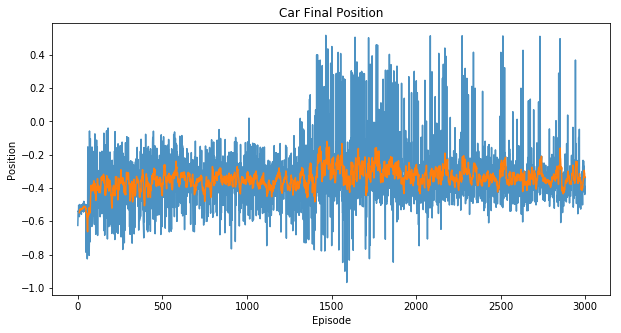

In [38]:
plt.figure(2, figsize=[10,5])
p = pd.Series(position)
ma = p.rolling(10).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.savefig('Final Position.png')
plt.show()

### Plot Policy

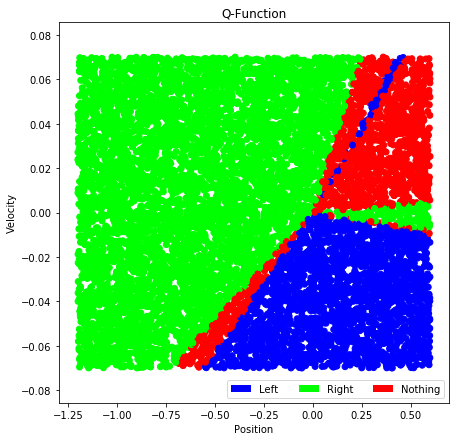

In [39]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

X = np.random.uniform(-1.2, 0.6, 10000)
Y = np.random.uniform(-0.07, 0.07, 10000)
Z = []
for i in range(len(X)):
    # Get the best action for the distribution of states
    _, temp = torch.max(q_func(np.array([X[i],Y[i]])), dim =-1)
    z = temp.item()
    Z.append(z)
Z = pd.Series(Z)
colors = {0:'blue',1:'lime',2:'red'}
colors = Z.apply(lambda x:colors[x])
labels = ['Left','Right','Nothing']

fig = plt.figure(3, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X,Y, c=Z)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Q-Function')
recs = []
for i in range(0,env.action_space.n):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=env.action_space.n)
fig.savefig('Q_function.png')
plt.show()

### Try trained Model

In [32]:
state = env.reset()
done = False
step = 0
while not done:
    Q = q_func(state)
    _, action = torch.max(Q, -1)
    action = action.item()
    
    next_state, reward, done, info = env.step(action)
    state = next_state
    step += 1
    print("Step: {}".format(step))
    env.render()
    clear_output(wait=True)

Step: 200
